In [1]:
!which pip3

/home/mgross/anaconda3/envs/contrast-net/bin/pip3


In [2]:
! nvidia-smi

Wed Jan 28 06:49:42 2026       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 8000                Off | 00000000:17:00.0 Off |                  Off |
| 33%   34C    P8              23W / 260W |   2118MiB / 49152MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import IPython
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import pandas as pd
import pytorch_lightning
from monai.visualize import img2tensorboard
import torch
import time
import sklearn

from torch.utils.data import DataLoader

import monai
from monai.transforms import \
    Compose, LoadImaged, AddChanneld, Orientationd, \
    NormalizeIntensityd, ScaleIntensityRangePercentilesd, \
    SpatialPadd, Spacingd, Resized, \
    RandCropByPosNegLabeld, ToTensord,  \
    DataStatsd, AsDiscrete, KeepLargestConnectedComponent, RandFlipd
#LoadNiftid


from monai.data import list_data_collate
from monai.networks.layers import Norm

# from monai.metrics import compute_meandice
from monai.transforms import KeepLargestConnectedComponent

from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm





monai.config.print_config()

MONAI version: 0.7.0
Numpy version: 1.20.3
Pytorch version: 1.8.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: bfa054b9c3064628a21f4c35bbe3132964e91f43

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 8.3.1
Tensorboard version: 2.6.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.9.2
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [4]:
print('CUDA available: ', torch.cuda.is_available())

n_gpus = torch.cuda.device_count()
for i in range(n_gpus):
    print('GPU %d: %s' % (i, torch.cuda.get_device_name(i)))


CUDA available:  True
GPU 0: Quadro RTX 8000


## Load the Data

In [5]:
INPUT_PATH = '../../ContrastNets.xlsx'
df = pd.read_excel(INPUT_PATH, index_col=False)

In [6]:
df_train, df_val, df_test = \
              np.split(df.sample(frac=1, random_state=50), 
                       [int(.7*len(df)), int(.85*len(df))])


df_train['DATA_SPLIT'] = 'Train'
df_val['DATA_SPLIT'] = 'Val'
df_test['DATA_SPLIT'] = 'Test'


df = pd.concat([df_train, df_val, df_test])

In [7]:
# Convert DF to dictionary
train_data_dict = df_train.to_dict('records')
val_data_dict = df_val.to_dict('records')
test_data_dict = df_test.to_dict('records')

## Setup Input Transformations

In [8]:
SPACING = (2.0,2.0,2.0)
#PATCH_SIZE = (96,96,16)
PATCH_SIZE = (64,64,32)




train_transforms = Compose([
    LoadImaged(keys=['ART', 'PV','SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['ART', 'PV', 'SEGM']),
    Orientationd(keys=['ART', 'PV', 'SEGM'], axcodes='RAS'),
    Spacingd(keys=['ART', 'PV', 'SEGM'], pixdim=SPACING, mode=('bilinear','bilinear', 'nearest'), padding_mode=('reflection', 'reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['ART', 'PV'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
    SpatialPadd(keys=['ART', 'PV', 'SEGM'], spatial_size=PATCH_SIZE, padding_mode=('reflection', 'reflection','reflection'), ),
#     DataStatsd(keys=['IMAGE','SEGM'], ARTfix=('train_image','train_segm')),
    # randomly crop out patch samples from big image based on pos / neg ratio
    # the image centers of negative samples must be in valid image area
    RandCropByPosNegLabeld(keys=['ART', 'PV', 'SEGM'], label_key='SEGM', spatial_size=PATCH_SIZE, pos=3, neg=1, num_samples=2),
    RandFlipd(keys=['ART', 'PV', 'SEGM'], prob=0.5, spatial_axis=0),
    ToTensord(keys=['ART', 'PV', 'SEGM'])
])

val_transforms = Compose([
    LoadImaged(keys=['ART', 'PV', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['ART', 'PV', 'SEGM']),
    Orientationd(keys=['ART', 'PV', 'SEGM'], axcodes='RAS'),
    Spacingd(keys=['ART', 'PV', 'SEGM'], pixdim=SPACING, mode=('bilinear','bilinear', 'nearest'), padding_mode=('reflection', 'reflection','reflection')),
    #Resized(keys=['ART', 'PV', 'DEL', 'LIVER_SEGM'], spatial_size=PATCH_SIZE),
    ScaleIntensityRangePercentilesd(keys=['ART', 'PV'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),    
#     DataStatsd(keys=['IMAGE','SEGM'], ARTfix=('val_image','val_segm')),
    ToTensord(keys=['ART', 'PV', 'SEGM'])
])

test_transforms = Compose([
    LoadImaged(keys=['ART', 'PV', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['ART', 'PV', 'SEGM']),
    Orientationd(keys=['ART', 'PV', 'SEGM'], axcodes='RAS'),
    Spacingd(keys=['ART', 'PV', 'SEGM'], pixdim=SPACING, mode=('bilinear','bilinear', 'nearest'), padding_mode=('reflection','reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['ART', 'PV'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], ARTfix=('val_image','val_segm')),
    ToTensord(keys=['ART', 'PV', 'SEGM'])
])


inference_transforms = Compose([
     LoadImaged(keys=['ART', 'PV'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['ART', 'PV']),
    Orientationd(keys=['ART', 'PV'], axcodes='RAS'),
    Spacingd(keys=['ART', 'PV'], pixdim=SPACING, mode=('bilinear','bilinear'), padding_mode=('reflection', 'reflection')),
    ScaleIntensityRangePercentilesd(keys=['ART', 'PV', 'DEL'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], ARTfix=('val_image','val_segm')),
    ToTensord(keys=['ART', 'PV'])
])



## Create a Persistent Data Cache for Training and Validation Data

In [9]:
CACHE_PATH = '/tensor5/data1/mgross/Liver/studies/Contrast-Nets/ART-PV-Net/monai_cache'


In [10]:
train_ds = monai.data.PersistentDataset(
    data=train_data_dict, transform=train_transforms, cache_dir=CACHE_PATH
)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4, collate_fn=list_data_collate)

In [11]:
val_ds = monai.data.PersistentDataset(
    data=val_data_dict, transform=val_transforms, cache_dir=CACHE_PATH
)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, collate_fn=list_data_collate)

In [12]:
test_ds = monai.data.Dataset(
    data=test_data_dict, transform=test_transforms)

test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

## Check Input Data

torch.Size([20, 1, 64, 64, 32])
torch.Size([20, 1, 64, 64, 32])
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.3450647294521332
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.48229822516441345


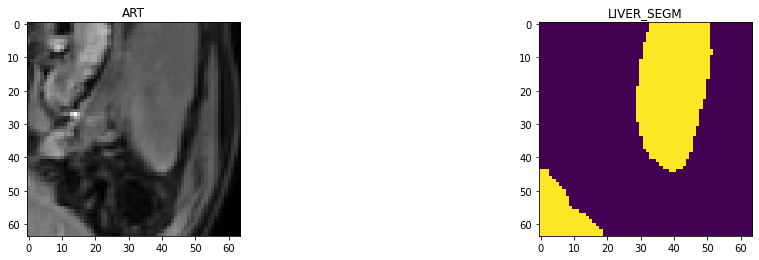

ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.716956377029419
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.9917463064193726


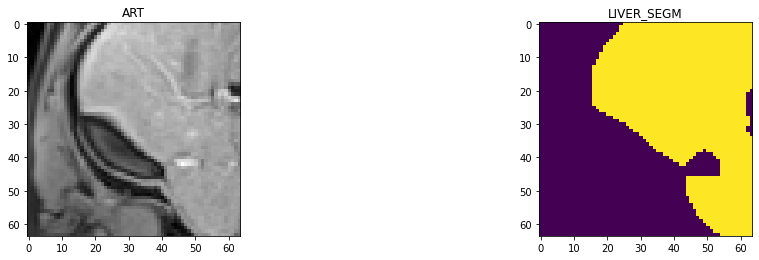

ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.6938133239746094
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.8666388988494873


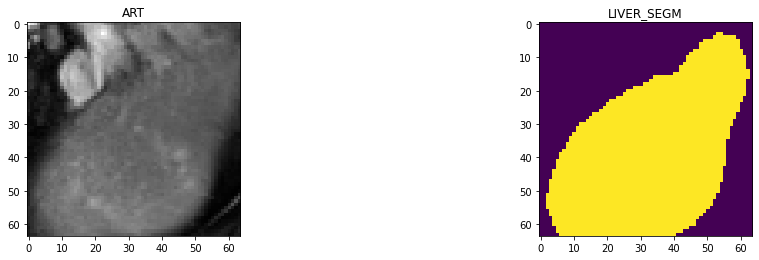

ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.8743233680725098
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 1.0172020196914673


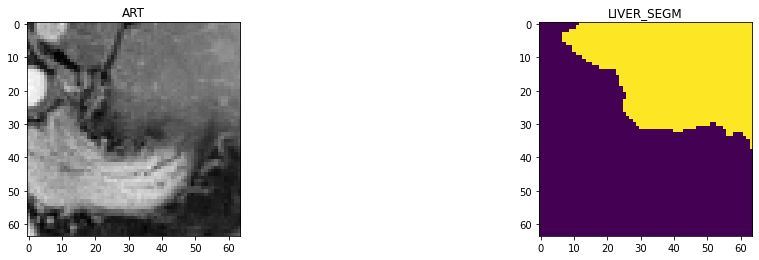

ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.47701945900917053
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.45547008514404297


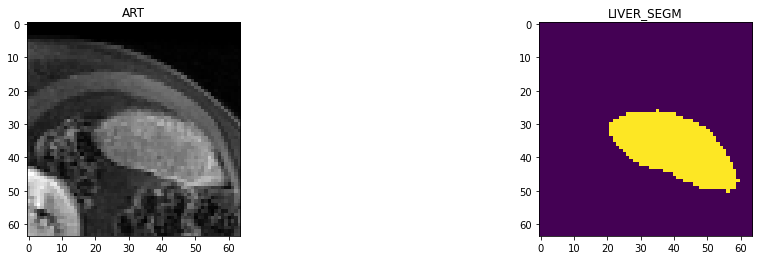

ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.5359461903572083
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.6215336322784424


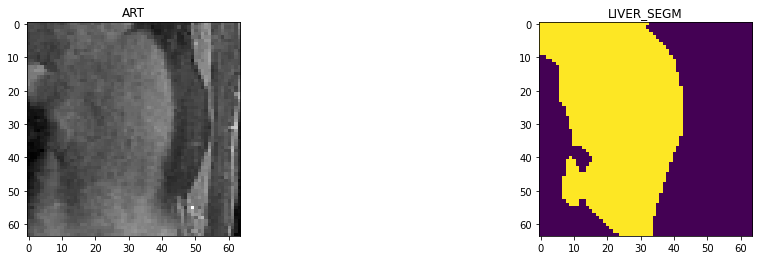

ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.6441585421562195
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.6426495313644409


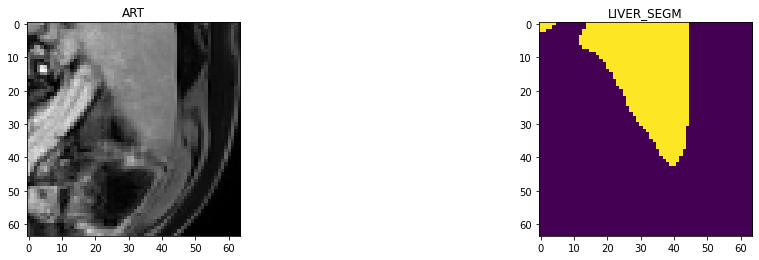

ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.9479333758354187
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.9249913096427917


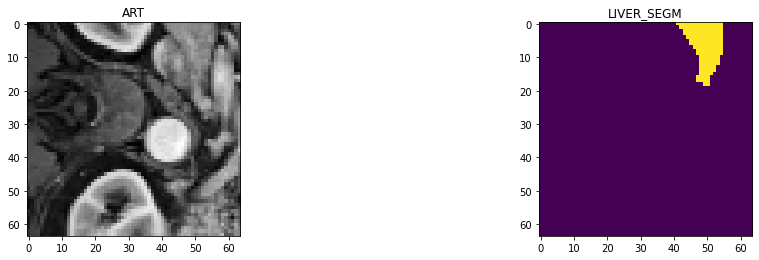

ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.0748848170042038
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.08032447099685669


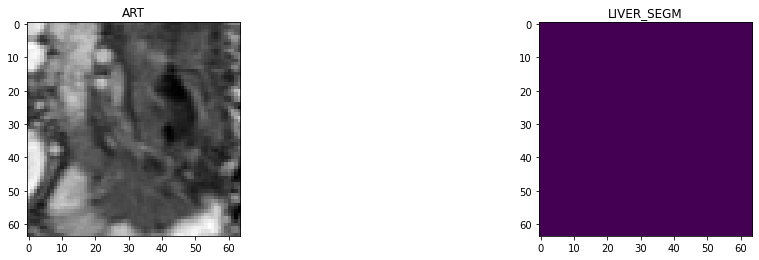

ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.5873064994812012
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.5406093001365662


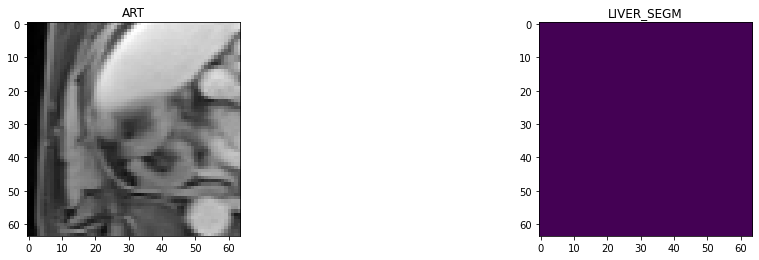

In [13]:
check_ds = monai.data.Dataset(data=train_data_dict[:10], transform=train_transforms)
#check_ds = monai.data.Dataset(data=val_data_dict[10:11], transform=val_transforms)
#check_ds = monai.data.Dataset(data=test_data_dict[:1], transform=test_transforms)

check_loader = DataLoader(check_ds, batch_size=10, num_workers=0, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['ART'].shape)
print(check_data['PV'].shape)


num_display = 10
if check_data['ART'].shape[0] < num_display:
    num_display = check_data['ART'].shape[0]

for i in range(num_display):
    ART, PV, liver_label = (check_data['ART'][i][0],check_data['PV'][i][0], check_data['SEGM'][i][0])


    
    print('ART shape: {}, label shape: {}'.format(ART.shape, liver_label.shape))
    print('ART mean: {}'.format(np.mean(ART.numpy())))
    
    
    print('PV shape: {}, label shape: {}'.format(PV.shape, liver_label.shape))
    print('PV mean: {}'.format(np.mean(PV.numpy())))
    
    slice_num = ART.shape[2]//2
    
    plt.figure('check', (13, 15))

    plt.subplot(1, 3, 1)
    plt.title('ART')
    plt.imshow(ART[:,:,slice_num], cmap='gray')

 
    
    plt.subplot(1, 3, 3)
    plt.title('PV')
    plt.imshow(PV[:,:,slice_num], cmap='gray')

    plt.subplot(1, 3 ,3)
    plt.title('LIVER_SEGM')
    plt.imshow(liver_label[:,:,slice_num])
    
    plt.show()



    


## Create Segmentation Model (U-net)

In [14]:
class MRILiverSegmentation(pytorch_lightning.LightningModule):

    def __init__(self, dropout_rate = 0.0):
        super().__init__()
        
        self._model = monai.networks.nets.UNet(
            dimensions=3, 
            in_channels=2, 
            out_channels=2, 
            channels=(16, 32, 64, 128),
            strides=(2, 2, 2), 
            num_res_units=2, 
            norm=Norm.BATCH,
            dropout = dropout_rate,
        )

    
        self.loss_function = monai.losses.DiceLoss(include_background=False, to_onehot_y=True, softmax=True)
        self.one_hot_transform = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
        self.val_metric = DiceMetric(include_background=False)

        self.best_val_dice = None
        self.best_val_epoch = None
        
        
    def forward(self, x):
        return self._model(x)

    
    def prepare_data(self):
        # set deterministic training for reproducibility
        set_determinism(seed=0)
    
    
    def training_step(self, batch, batch_idx):

        art_images =  batch["ART"]
        pv_images =  batch["PV"]
        
        
        images = torch.cat((art_images, pv_images) ,dim=1)
        labels = batch["SEGM"]

        
        
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        return {"loss": loss}
    
    
    def training_epoch_end(self, outputs):
        # Only add the graph at the first epoch
        if self.current_epoch==1:
            #sample_input = torch.rand((1,1,96,96,16))
            sample_input = torch.rand((1,2,64,64,32))
            self.logger.experiment.add_graph(
                MRILiverSegmentation(), 
                [sample_input])
        
        # Calculate the average loss
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Train/Loss', avg_loss, self.current_epoch)
    
    

    def validation_step(self, batch, batch_idx):
        
        
        art_images =  batch["ART"]
        pv_images =  batch["PV"]
        

        
        images = torch.cat((art_images, pv_images) ,dim=1)
        labels = batch["SEGM"]
        
        
        #images = batch["IMAGE"]
        #labels = batch["SEGM"]

        #roi_size = (256, 256, 48)
        roi_size = (224, 224, 128)
        sw_batch_size = 4
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)

        loss = self.loss_function(outputs, labels)

#         one_hot = monai.networks.utils.one_hot(labels, num_classes=3)
        argmax = torch.argmax(outputs, dim=1, keepdim=True)
        val_dice = self.val_metric(
            self.one_hot_transform(argmax), 
            self.one_hot_transform(labels)
        )
                
        if batch_idx<1:
            img2tensorboard.plot_2d_or_3d_image(data=images, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Input')
            img2tensorboard.plot_2d_or_3d_image(data=argmax, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Output')

        return {"val_loss": loss, "val_dice": val_dice}
    
    def validation_epoch_end(self, outputs):
        # Calculate the average loss
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_dice = torch.stack([x['val_dice'][0] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Val/Loss', avg_loss, self.current_epoch)
        self.logger.experiment.add_scalar('Val/Dice', avg_dice, self.current_epoch)
        
        self.log('val_loss', avg_loss)
        self.log('val_dice', avg_dice)

    
    def configure_optimizers(self):
        return torch.optim.Adam(self._model.parameters(), lr=1e-4)
    
    

In [15]:
from torchinfo import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MRILiverSegmentation()
#summary(model.to(device), [1,1,96,96,16])
summary(model.to(device), [1,2,64,64,32])

Layer (type:depth-idx)                                                           Output Shape              Param #
MRILiverSegmentation                                                             --                        --
├─UNet: 1-1                                                                      [1, 2, 64, 64, 32]        --
│    └─Sequential: 2-1                                                           [1, 2, 64, 64, 32]        --
│    │    └─ResidualUnit: 3-1                                                    [1, 16, 32, 32, 16]       8,754
│    │    └─SkipConnection: 3-2                                                  [1, 32, 32, 32, 16]       1,178,186
│    │    └─Sequential: 3-3                                                      [1, 2, 64, 64, 32]        1,845
Total params: 1,188,785
Trainable params: 1,188,785
Non-trainable params: 0
Total mult-adds (G): 1.69
Input size (MB): 1.05
Forward/backward pass size (MB): 45.22
Params size (MB): 4.76
Estimated Total Size (MB):

## Model Training

In [16]:
MODEL_ROOT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/ART-PV-Net/'


In [17]:
# initialise the LightningModule
model = MRILiverSegmentation(dropout_rate=0.3)

# set up loggers and checkpoints
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(
    save_dir=os.path.join(MODEL_ROOT_PATH,'saved_model','logs')
)

lr_monitor = pytorch_lightning.callbacks.LearningRateMonitor(logging_interval='epoch')

checkpoint_callback = pytorch_lightning.callbacks.ModelCheckpoint(
    dirpath=os.path.join(MODEL_ROOT_PATH,'saved_model'),
    filename="MRILiverSegmentation-{epoch:04d}-{val_loss:.2f}",
    monitor='val_loss',
    save_last=True,
    save_on_train_epoch_end=True,
    save_top_k=2,
    mode='min'
)

# check for last checkpoint
resume_checkpoint = None
if os.path.exists(os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')):
    resume_checkpoint = os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=[0],
    max_epochs=2000,
    logger=tb_logger,
    callbacks=[lr_monitor,checkpoint_callback],
    num_sanity_val_steps=1,
    check_val_every_n_epoch=20,
    resume_from_checkpoint=resume_checkpoint
)

# train
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:45: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:730: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1893: LightningDeprecationWarning: `trainer.resume_from_checkpoint` is deprecated in v1.5 and will be removed in v1.7. Specify the fit ch

Validation sanity check: 0it [00:00, ?it/s]

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 7. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


## Model Testing

In [18]:
model_path = os.path.join(MODEL_ROOT_PATH,'saved_model','MRILiverSegmentation-epoch=1059-val_loss=0.06.ckpt')

In [19]:
model = MRILiverSegmentation.load_from_checkpoint(model_path)
# model.load_from_checkpoint(model_path)
model.eval()
device = torch.device("cuda:0")
model.to(device)

MRILiverSegmentation(
  (_model): UNet(
    (model): Sequential(
      (0): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
          (unit1): Convolution(
            (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
        )
        (residual): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      )
      (1): SkipConnection(
        

In [20]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import torch
import time


from monai.transforms import KeepLargestConnectedComponent
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm
from monai.data import decollate_batch




def compute_evaluation_metrics(y_pred, y, keep=False):
    
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    hd = monai.metrics.HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95, get_not_nans=False)
    mad = monai.metrics.SurfaceDistanceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep_largest = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    dice_list = list()
    hd_list = list()
    mad_list = list()
    for y_pred_i, y_i in decollate_batch((y_pred, y)):
        print(y_pred_i.shape)
        print(y_i.shape)
        if keep:
            #dice(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #hd(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #mad(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            y_pred_i_proc=one_hot(keep_largest(argmax(y_pred_i)))
        else:
                
            # Calculate Dice on the raw output
            #dice(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #hd(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #mad(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            y_pred_i_proc = one_hot(argmax(y_pred_i))
        y_pred_i_proc = monai.transforms.AddChannel()(y_pred_i_proc)
        y_i_proc = monai.transforms.AddChannel()(one_hot(y_i))
        print(y_pred_i_proc.shape)
            
        #dice(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #hd(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #mad(y_pred=y_pred_i_proc, y=one_hot(y_i))
            
        dice(y_pred=y_pred_i_proc, y=y_i_proc)
        hd(y_pred=y_pred_i_proc, y=y_i_proc)
        mad(y_pred=y_pred_i_proc, y=y_i_proc)
        
        dice_value = dice.aggregate().item()
        hd_value = hd.aggregate().item()
        mad_value = mad.aggregate().item()
        
        print(dice_value)
        print(hd_value)
        print(mad_value)
        
        dice_list.append(dice_value)
        hd_list.append(hd_value)
        mad_list.append(mad_value)
              
    return dice_list, hd_list, mad_list


def run_inference_and_evaluate(model, data_loader, plot_images=False, max_eval=None, 
                               save_output=False,roi_size=(224,224,128), sw_batch_size=4, output_path=None):
    
    """Inference and evaluation function for Liver segmentation.
    
    """   
    
    df_eval = pd.DataFrame()
    
    acc_ids = list()
    input_paths = list()
    output_paths = list()
    
    original_dice_results = list()
    postprocess_dice_results = list()

    original_hd_results = list()
    postprocess_hd_results = list()

    original_mad_results = list()
    postprocess_mad_results = list()
    
    inference_times = list()
    


    
    # Use MONAI one_hot transform
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    with torch.no_grad():
        for i, test_data in tqdm(enumerate(data_loader)):
        # Early stopping
            if max_eval is not None:
                if i>=max_eval:
                    break

            #print(test_data['ACCESSION_ID'][0])
            #for val in test_data['ACCESSION_ID'][0]:
            #    acc_ids.append(val)

    
            art_images =  test_data["ART"].to(device)
            pv_images =  test_data["PV"].to(device)
            
            x = torch.cat((art_images, pv_images) ,dim=1)
            y = test_data['SEGM'].cpu()




            start_time = time.time()
            y_pred = sliding_window_inference(x, roi_size, sw_batch_size, model)
            stop_time = time.time()

            inference_time = stop_time-start_time
            inference_times.append(inference_time)

            x = x.detach().cpu()
            y_pred = y_pred.detach().cpu()
            #print(y_pred.shape)

            #argmax = torch.argmax(y_pred, dim=1, keepdim=True)
            #argmax = argmax.detach().cpu()

            #y_onehot = one_hot(y)
            #y_pred_onehot = one_hot(argmax)

            # Evaluate segmentation metrics
            eval_list = list()
            # Update to MONAI 0.7+
            dice_values, hd_values, mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y
            )

            for val in dice_values:
                original_dice_results.append(val)
            for val in hd_values:
                original_hd_results.append(val)
            for val in mad_values:
                original_mad_results.append(val)



            post_dice_values, post_hd_values, post_mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y, keep=True
            )        #dice_list = list()
            #post_dice_list = list()

            for val in post_dice_values:
                postprocess_dice_results.append(val)
            for val in post_hd_values:
                postprocess_hd_results.append(val)
            for val in post_mad_values:
                postprocess_mad_results.append(val)





            print(y_pred.shape)
            print(argmax(y_pred[0,...]).shape)


            if plot_images:
                art_img = art_images.detach().cpu()
                pv_img = pv_images.detach().cpu()
                


                slice_num = x.shape[-1]//2

                plt.figure('check', (9, 3))
                plt.subplot(1, 4, 1)
                plt.title('ART')
                plt.imshow(art_img[0,0,:,:,slice_num], cmap='gray')

                plt.subplot(1, 4, 1)
                plt.title('PV')
                plt.imshow(pv_img[0,0,:,:,slice_num], cmap='gray')

            
                plt.subplot(1, 4, 3)
                plt.title('SEGM')
                plt.imshow(y[0,0,:,:,slice_num])

                plt.subplot(1, 4, 4)
                plt.title('PRED')
                #plt.imshow(argmax(y_pred[0,...])[0,:,:,slice_num])
                plt.imshow(keep(argmax(y_pred[0,...]))[0,:,:,slice_num])
                plt.show()


            # Write data out
            if save_output:
                # Get the image affine matrix
                current_affine = test_data['PV_meta_dict']['affine'][0].numpy()
                original_affine = test_data['PV_meta_dict']['original_affine'][0].numpy()
                original_spatial_shape = test_data['PV_meta_dict']['spatial_shape'][0].numpy()

                input_file_name = test_data['PV_meta_dict']['filename_or_obj'][0]
                output_file_name = os.path.split(input_file_name)[1]
                output_root_name = output_file_name[:-len('.nii.gz')]
                output_path_final = os.path.join(output_path,'{}_segm.nii.gz'.format(output_root_name))
                print('Saving segmentation results: {}'.format(output_path_final))
                
                output_paths.append(output_path_final)
                
                #output_segm = argmax.cpu()[0, 0,...].numpy()
                output_segm = keep(argmax(y_pred[0,...])).cpu()[0,...].numpy()
                write_nifti(output_segm, output_path_final,
                            mode='nearest',
                            affine=current_affine, 
                            target_affine=original_affine,
                            output_spatial_shape=original_spatial_shape, 
                            dtype=np.float32
                           )

    
    #df_eval['ACCESSION_ID'] = acc_ids
    #df_eval['PV'] = input_paths
    df_eval['DICE'] = original_dice_results
    print(original_dice_results)
    df_eval['POST_DICE'] = postprocess_dice_results
    df_eval['HD95'] = original_hd_results
    df_eval['POST_HD95'] = postprocess_hd_results
    #df_eval['MAD'] = original_mad_results
    #df_eval['POST_MAD'] = postprocess_mad_results
    df_eval['InferenceTime'] = inference_times
    if output_path is not None:
        df_eval['AUTOMATED-LIVER-SEGM'] = output_paths    
    return df_eval


In [21]:
OUTPUT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases'

0it [00:00, ?it/s]

torch.Size([2, 201, 151, 108])
torch.Size([1, 201, 151, 108])
torch.Size([1, 2, 201, 151, 108])
0.9713834524154663
1.4142135623730951
1.5027920217827633
torch.Size([2, 201, 151, 108])
torch.Size([1, 201, 151, 108])
torch.Size([1, 2, 201, 151, 108])
0.9722552299499512
1.4142135623730951
0.3926395605812905
torch.Size([1, 2, 201, 151, 108])
torch.Size([1, 201, 151, 108])


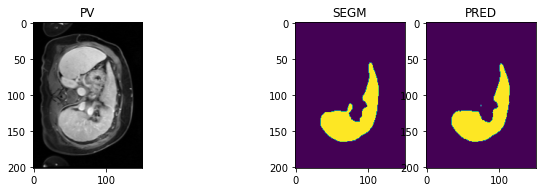

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E100998852_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.9620359539985657
59.00084739677276
5.3155611635402815
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.9761836528778076
1.4142135623730951
0.40391042222088075
torch.Size([1, 2, 190, 143, 120])
torch.Size([1, 190, 143, 120])


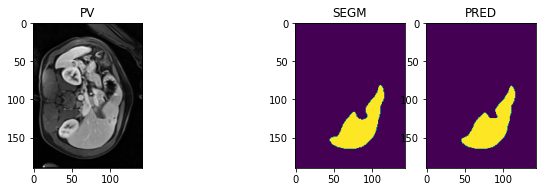

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/12370686_T1_PV_REG_segm.nii.gz
torch.Size([2, 220, 177, 120])
torch.Size([1, 220, 177, 120])
torch.Size([1, 2, 220, 177, 120])
0.950715184211731
39.81205847478876
7.295010800256172
torch.Size([2, 220, 177, 120])
torch.Size([1, 220, 177, 120])
torch.Size([1, 2, 220, 177, 120])
0.970980703830719
1.4142135623730951
0.4136895278737957
torch.Size([1, 2, 220, 177, 120])
torch.Size([1, 220, 177, 120])


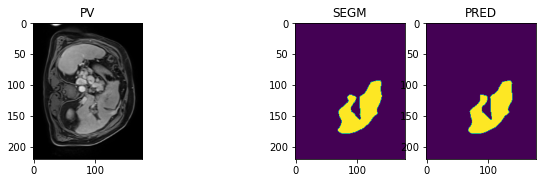

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E104184251_T1_PV_REG_segm.nii.gz
torch.Size([2, 230, 230, 144])
torch.Size([1, 230, 230, 144])
torch.Size([1, 2, 230, 230, 144])
0.8582643270492554
75.71096350225376
20.505122284912126
torch.Size([2, 230, 230, 144])
torch.Size([1, 230, 230, 144])
torch.Size([1, 2, 230, 230, 144])
0.9764707684516907
1.0
0.4023974435830258
torch.Size([1, 2, 230, 230, 144])
torch.Size([1, 230, 230, 144])


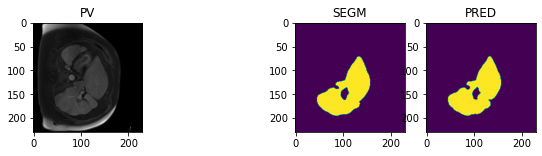

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E100353838_T1_PV_REG_segm.nii.gz
torch.Size([2, 210, 158, 95])
torch.Size([1, 210, 158, 95])
torch.Size([1, 2, 210, 158, 95])
0.955176830291748
57.8013840664737
9.372434956296361
torch.Size([2, 210, 158, 95])
torch.Size([1, 210, 158, 95])
torch.Size([1, 2, 210, 158, 95])
0.9635244011878967
2.0
0.5765737854741527
torch.Size([1, 2, 210, 158, 95])
torch.Size([1, 210, 158, 95])


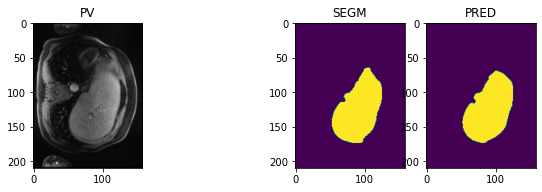

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/11655071_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.9629046320915222
1.4142135623730951
0.43500340713589464
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.9629046320915222
1.4142135623730951
0.43500340713589464
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


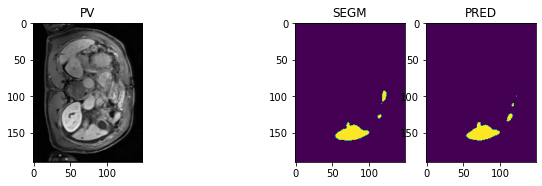

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E105258820_T1_PV_REG_segm.nii.gz
torch.Size([2, 180, 169, 140])
torch.Size([1, 180, 169, 140])
torch.Size([1, 2, 180, 169, 140])
0.9789929986000061
1.4142135623730951
0.46352685781352154
torch.Size([2, 180, 169, 140])
torch.Size([1, 180, 169, 140])
torch.Size([1, 2, 180, 169, 140])
0.9789929986000061
1.4142135623730951
0.46352685781352154
torch.Size([1, 2, 180, 169, 140])
torch.Size([1, 180, 169, 140])


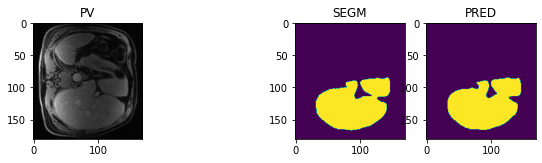

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/10782833_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.9657390713691711
54.71745608121781
5.340863667218527
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.9790592789649963
1.0
0.3337873052363794
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


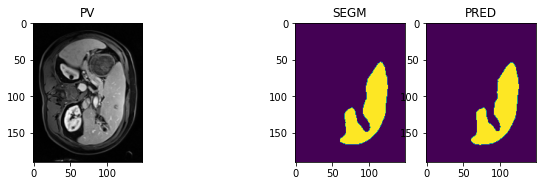

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E105047582_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 156, 120])
torch.Size([1, 200, 156, 120])
torch.Size([1, 2, 200, 156, 120])
0.9170084595680237
68.07055138211486
10.833627245240027
torch.Size([2, 200, 156, 120])
torch.Size([1, 200, 156, 120])
torch.Size([1, 2, 200, 156, 120])
0.95322185754776
2.0
0.6635116292005048
torch.Size([1, 2, 200, 156, 120])
torch.Size([1, 200, 156, 120])


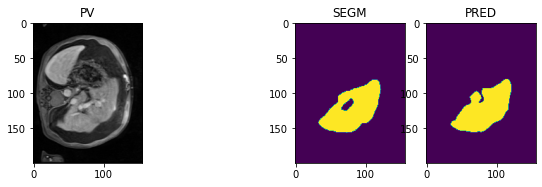

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E100559269_T1_PV_REG_segm.nii.gz
torch.Size([2, 180, 147, 132])
torch.Size([1, 180, 147, 132])
torch.Size([1, 2, 180, 147, 132])
0.857477605342865
50.96076922496363
8.741834793114013
torch.Size([2, 180, 147, 132])
torch.Size([1, 180, 147, 132])
torch.Size([1, 2, 180, 147, 132])
0.9370614886283875
3.7416573867739413
0.8950921150390069
torch.Size([1, 2, 180, 147, 132])
torch.Size([1, 180, 147, 132])


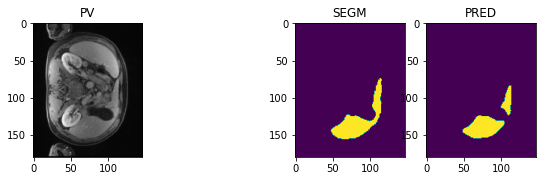

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/11157922_T1_PV_REG_segm.nii.gz
torch.Size([2, 203, 172, 116])
torch.Size([1, 203, 172, 116])
torch.Size([1, 2, 203, 172, 116])
0.9613134264945984
5.385164807134504
0.9898523173048899
torch.Size([2, 203, 172, 116])
torch.Size([1, 203, 172, 116])
torch.Size([1, 2, 203, 172, 116])
0.9613134264945984
5.385164807134504
0.9898523173048899
torch.Size([1, 2, 203, 172, 116])
torch.Size([1, 203, 172, 116])


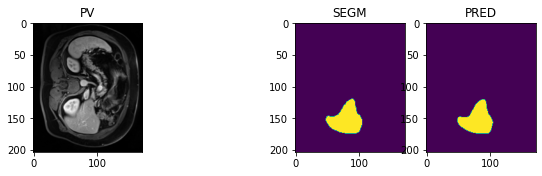

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E103977998_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 155, 120])
torch.Size([1, 190, 155, 120])
torch.Size([1, 2, 190, 155, 120])
0.9600239992141724
3.7416573867739413
1.6928296362224535
torch.Size([2, 190, 155, 120])
torch.Size([1, 190, 155, 120])
torch.Size([1, 2, 190, 155, 120])
0.9636363387107849
2.449489742783178
0.5791909916250066
torch.Size([1, 2, 190, 155, 120])
torch.Size([1, 190, 155, 120])


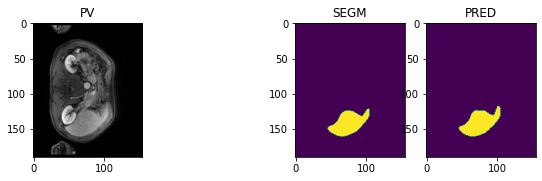

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E106605970_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.8037298321723938
68.19824044651006
21.804869168276603
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.9612640142440796
5.0
0.5428297370005809
torch.Size([1, 2, 200, 163, 120])
torch.Size([1, 200, 163, 120])


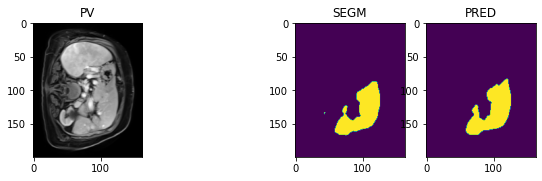

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E101166449_T1_PV_REG_segm.nii.gz
torch.Size([2, 221, 221, 110])
torch.Size([1, 221, 221, 110])
torch.Size([1, 2, 221, 221, 110])
0.9282627105712891
65.49809157525127
12.004579964965075
torch.Size([2, 221, 221, 110])
torch.Size([1, 221, 221, 110])
torch.Size([1, 2, 221, 221, 110])
0.9695456027984619
2.0
0.5683239282892656
torch.Size([1, 2, 221, 221, 110])
torch.Size([1, 221, 221, 110])


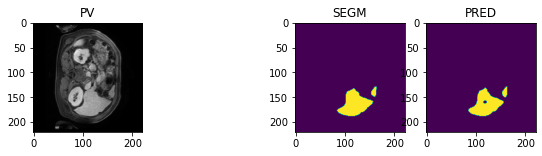

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E101693803_T1_PV_REG_segm.nii.gz
torch.Size([2, 205, 160, 120])
torch.Size([1, 205, 160, 120])
torch.Size([1, 2, 205, 160, 120])
0.9712070226669312
1.4142135623730951
0.9379103756938066
torch.Size([2, 205, 160, 120])
torch.Size([1, 205, 160, 120])
torch.Size([1, 2, 205, 160, 120])
0.972654402256012
1.4142135623730951
0.38482739301047064
torch.Size([1, 2, 205, 160, 120])
torch.Size([1, 205, 160, 120])


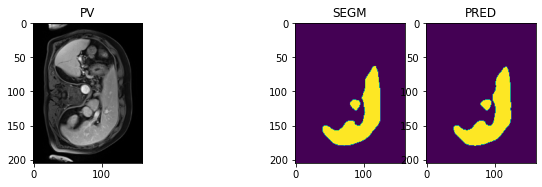

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E100488381_T1_PV_REG_segm.nii.gz
torch.Size([2, 225, 176, 132])
torch.Size([1, 225, 176, 132])
torch.Size([1, 2, 225, 176, 132])
0.9598252177238464
4.888551299279361
3.5113838026903577
torch.Size([2, 225, 176, 132])
torch.Size([1, 225, 176, 132])
torch.Size([1, 2, 225, 176, 132])
0.9634258151054382
4.358898943540674
0.5091268734112574
torch.Size([1, 2, 225, 176, 132])
torch.Size([1, 225, 176, 132])


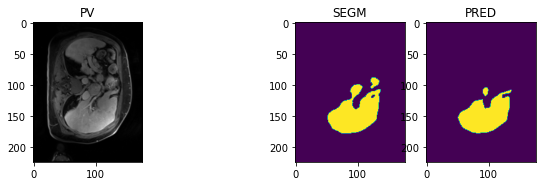

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E101446184_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 127, 108])
torch.Size([1, 190, 127, 108])
torch.Size([1, 2, 190, 127, 108])
0.9666485786437988
1.7320508075688772
2.3025954142997516
torch.Size([2, 190, 127, 108])
torch.Size([1, 190, 127, 108])
torch.Size([1, 2, 190, 127, 108])
0.9677907228469849
1.7320508075688772
0.46201353052930105
torch.Size([1, 2, 190, 127, 108])
torch.Size([1, 190, 127, 108])


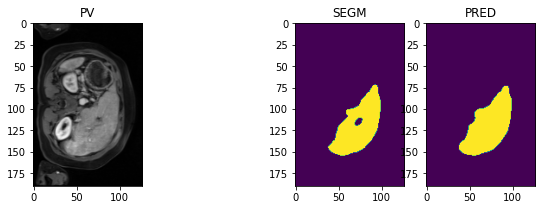

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/12132879_T1_PV_REG_segm.nii.gz
torch.Size([2, 250, 187, 132])
torch.Size([1, 250, 187, 132])
torch.Size([1, 2, 250, 187, 132])
0.9782244563102722
1.0
0.3698005073961847
torch.Size([2, 250, 187, 132])
torch.Size([1, 250, 187, 132])
torch.Size([1, 2, 250, 187, 132])
0.9782244563102722
1.0
0.3698005073961847
torch.Size([1, 2, 250, 187, 132])
torch.Size([1, 250, 187, 132])


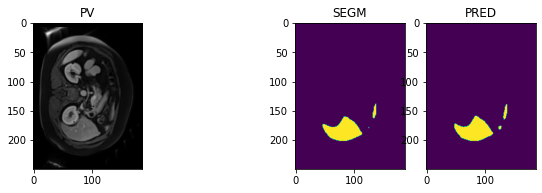

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E100207522_T1_PV_REG_segm.nii.gz
torch.Size([2, 210, 169, 120])
torch.Size([1, 210, 169, 120])
torch.Size([1, 2, 210, 169, 120])
0.860634446144104
72.98904000312773
18.873042727445313
torch.Size([2, 210, 169, 120])
torch.Size([1, 210, 169, 120])
torch.Size([1, 2, 210, 169, 120])
0.9704652428627014
1.4142135623730951
0.5225813233241067
torch.Size([1, 2, 210, 169, 120])
torch.Size([1, 210, 169, 120])


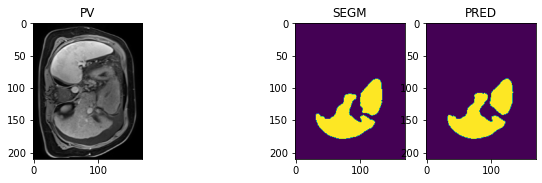

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E104350920_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.9525139927864075
38.948684188300895
4.669406853523184
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.961089015007019
1.7320508075688772
0.5766039917881317
torch.Size([1, 2, 190, 143, 120])
torch.Size([1, 190, 143, 120])


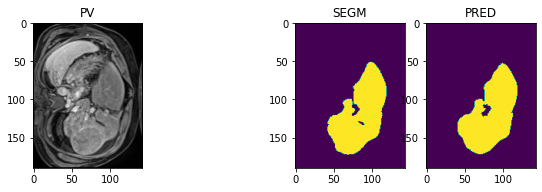

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E103442524_T1_PV_REG_segm.nii.gz
torch.Size([2, 210, 210, 132])
torch.Size([1, 210, 210, 132])
torch.Size([1, 2, 210, 210, 132])
0.956264853477478
37.37378722255696
5.298410977511276
torch.Size([2, 210, 210, 132])
torch.Size([1, 210, 210, 132])
torch.Size([1, 2, 210, 210, 132])
0.9754676818847656
1.7320508075688772
0.46552620479320783
torch.Size([1, 2, 210, 210, 132])
torch.Size([1, 210, 210, 132])


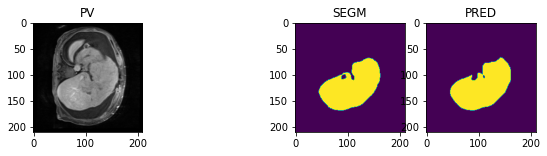

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E100354995_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 157, 120])
torch.Size([1, 200, 157, 120])
torch.Size([1, 2, 200, 157, 120])
0.9268923997879028
65.1148975216925
12.029560460622843
torch.Size([2, 200, 157, 120])
torch.Size([1, 200, 157, 120])
torch.Size([1, 2, 200, 157, 120])
0.9749748706817627
1.4142135623730951
0.42750793058942815
torch.Size([1, 2, 200, 157, 120])
torch.Size([1, 200, 157, 120])


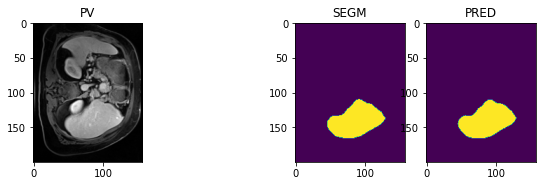

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/12169194_T1_PV_REG_segm.nii.gz
torch.Size([2, 191, 191, 88])
torch.Size([1, 191, 191, 88])
torch.Size([1, 2, 191, 191, 88])
0.7992457151412964
66.64082832618455
20.595371729999123
torch.Size([2, 191, 191, 88])
torch.Size([1, 191, 191, 88])
torch.Size([1, 2, 191, 191, 88])
0.9721835851669312
1.4142135623730951
0.4205255709882478
torch.Size([1, 2, 191, 191, 88])
torch.Size([1, 191, 191, 88])


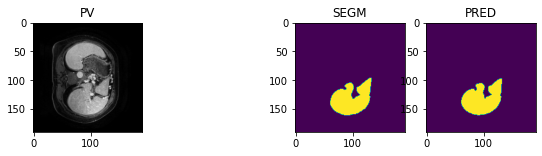

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/9464709_T1_PV_REG_segm.nii.gz
torch.Size([2, 221, 221, 144])
torch.Size([1, 221, 221, 144])
torch.Size([1, 2, 221, 221, 144])
0.9139358997344971
88.14193099768123
21.836991874530728
torch.Size([2, 221, 221, 144])
torch.Size([1, 221, 221, 144])
torch.Size([1, 2, 221, 221, 144])
0.9756295084953308
1.0
0.41539425718134826
torch.Size([1, 2, 221, 221, 144])
torch.Size([1, 221, 221, 144])


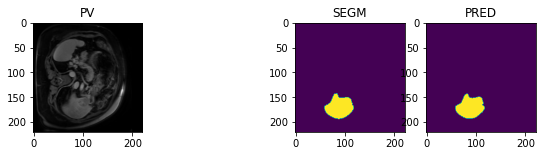

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E102885531_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 163, 108])
torch.Size([1, 200, 163, 108])
torch.Size([1, 2, 200, 163, 108])
0.9686031341552734
1.7320508075688772
1.2020371694899081
torch.Size([2, 200, 163, 108])
torch.Size([1, 200, 163, 108])
torch.Size([1, 2, 200, 163, 108])
0.9692404270172119
1.4142135623730951
0.494741009808265
torch.Size([1, 2, 200, 163, 108])
torch.Size([1, 200, 163, 108])


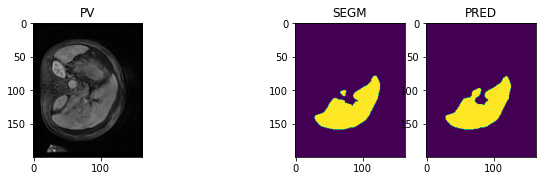

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E106731917_T1_PV_REG_segm.nii.gz
torch.Size([2, 211, 211, 131])
torch.Size([1, 211, 211, 131])
torch.Size([1, 2, 211, 211, 131])
0.9387735724449158
78.15017564303196
6.251377489207449
torch.Size([2, 211, 211, 131])
torch.Size([1, 211, 211, 131])
torch.Size([1, 2, 211, 211, 131])
0.9509279131889343
7.211102550927978
0.49712015564407525
torch.Size([1, 2, 211, 211, 131])
torch.Size([1, 211, 211, 131])


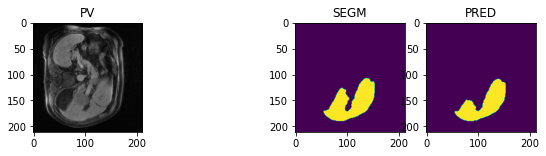

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E105877173_T1_PV_REG_segm.nii.gz
torch.Size([2, 175, 143, 108])
torch.Size([1, 175, 143, 108])
torch.Size([1, 2, 175, 143, 108])
0.974003255367279
1.4142135623730951
1.3658007458686772
torch.Size([2, 175, 143, 108])
torch.Size([1, 175, 143, 108])
torch.Size([1, 2, 175, 143, 108])
0.9763184785842896
1.0
0.3800145019956423
torch.Size([1, 2, 175, 143, 108])
torch.Size([1, 175, 143, 108])


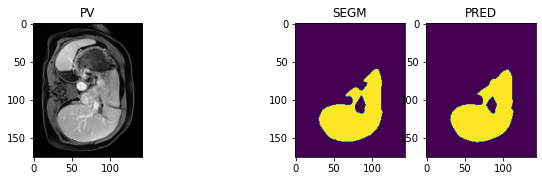

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E106096969_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 184, 120])
torch.Size([1, 190, 184, 120])
torch.Size([1, 2, 190, 184, 120])
0.965411365032196
2.0
2.347318867994365
torch.Size([2, 190, 184, 120])
torch.Size([1, 190, 184, 120])
torch.Size([1, 2, 190, 184, 120])
0.9688911437988281
1.4142135623730951
0.48285947674241125
torch.Size([1, 2, 190, 184, 120])
torch.Size([1, 190, 184, 120])


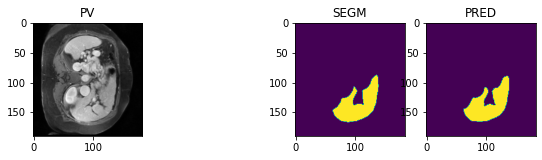

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/11571840_T1_PV_REG_segm.nii.gz
torch.Size([2, 220, 165, 131])
torch.Size([1, 220, 165, 131])
torch.Size([1, 2, 220, 165, 131])
0.971438467502594
1.4142135623730951
1.173384752261907
torch.Size([2, 220, 165, 131])
torch.Size([1, 220, 165, 131])
torch.Size([1, 2, 220, 165, 131])
0.9723683595657349
1.4142135623730951
0.44870422556658945
torch.Size([1, 2, 220, 165, 131])
torch.Size([1, 220, 165, 131])


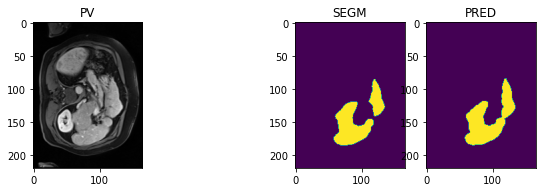

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E101753253_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 155, 120])
torch.Size([1, 190, 155, 120])
torch.Size([1, 2, 190, 155, 120])
0.9796627759933472
1.0
0.34781613002645234
torch.Size([2, 190, 155, 120])
torch.Size([1, 190, 155, 120])
torch.Size([1, 2, 190, 155, 120])
0.9796627759933472
1.0
0.34781613002645234
torch.Size([1, 2, 190, 155, 120])
torch.Size([1, 190, 155, 120])


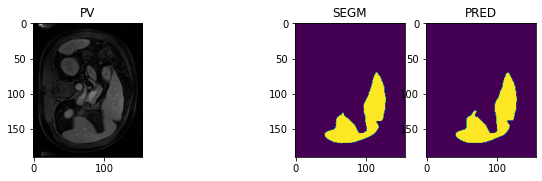

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E103922902_T1_PV_REG_segm.nii.gz
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9476144313812256
71.99583192643219
9.62465841489706
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9721120595932007
1.4142135623730951
0.49696825473705725
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


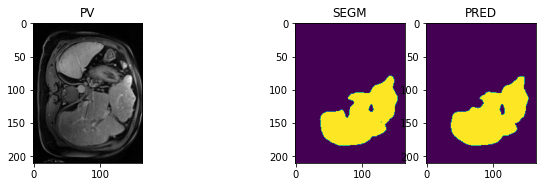

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E101453378_T1_PV_REG_segm.nii.gz
torch.Size([2, 180, 146, 102])
torch.Size([1, 180, 146, 102])
torch.Size([1, 2, 180, 146, 102])
0.9707602262496948
1.7320508075688772
0.5526601005294722
torch.Size([2, 180, 146, 102])
torch.Size([1, 180, 146, 102])
torch.Size([1, 2, 180, 146, 102])
0.9707800149917603
1.7320508075688772
0.5325912788616411
torch.Size([1, 2, 180, 146, 102])
torch.Size([1, 180, 146, 102])


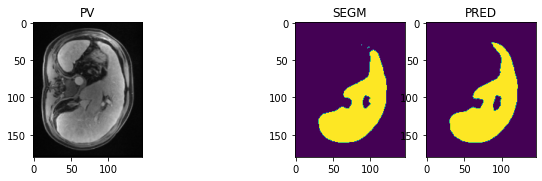

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/11397044_T1_PV_REG_segm.nii.gz
torch.Size([2, 210, 158, 120])
torch.Size([1, 210, 158, 120])
torch.Size([1, 2, 210, 158, 120])
0.9423151016235352
37.8549864614954
5.514226976975777
torch.Size([2, 210, 158, 120])
torch.Size([1, 210, 158, 120])
torch.Size([1, 2, 210, 158, 120])
0.9743304252624512
1.4142135623730951
0.4068458484876005
torch.Size([1, 2, 210, 158, 120])
torch.Size([1, 210, 158, 120])


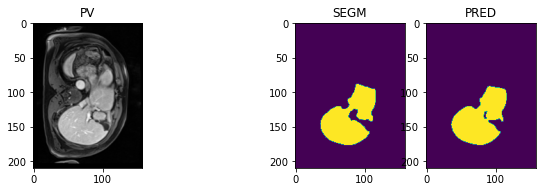

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/12922235_T1_PV_REG_segm.nii.gz
torch.Size([2, 185, 151, 120])
torch.Size([1, 185, 151, 120])
torch.Size([1, 2, 185, 151, 120])
0.9675701260566711
2.0
0.5071237751474464
torch.Size([2, 185, 151, 120])
torch.Size([1, 185, 151, 120])
torch.Size([1, 2, 185, 151, 120])
0.967581033706665
2.0
0.5054111522725657
torch.Size([1, 2, 185, 151, 120])
torch.Size([1, 185, 151, 120])


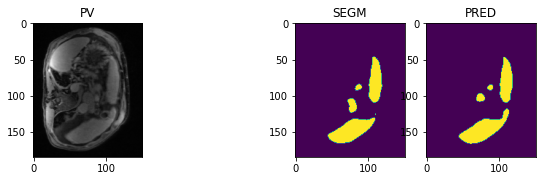

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/10939089_T1_PV_REG_segm.nii.gz
torch.Size([2, 225, 149, 144])
torch.Size([1, 225, 149, 144])
torch.Size([1, 2, 225, 149, 144])
0.9765977263450623
1.4142135623730951
0.3684943096559064
torch.Size([2, 225, 149, 144])
torch.Size([1, 225, 149, 144])
torch.Size([1, 2, 225, 149, 144])
0.9765977263450623
1.4142135623730951
0.3684943096559064
torch.Size([1, 2, 225, 149, 144])
torch.Size([1, 225, 149, 144])


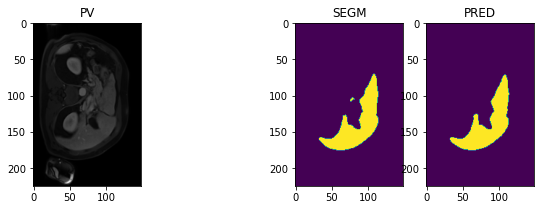

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/12957044_T1_PV_REG_segm.nii.gz
torch.Size([2, 220, 179, 120])
torch.Size([1, 220, 179, 120])
torch.Size([1, 2, 220, 179, 120])
0.9709125757217407
2.0
0.8521028372801889
torch.Size([2, 220, 179, 120])
torch.Size([1, 220, 179, 120])
torch.Size([1, 2, 220, 179, 120])
0.9716743230819702
1.7320508075688772
0.5181761235192597
torch.Size([1, 2, 220, 179, 120])
torch.Size([1, 220, 179, 120])


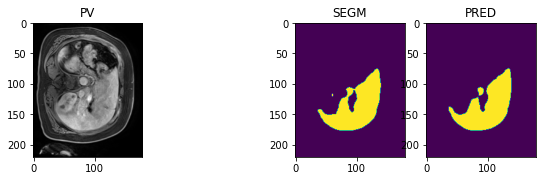

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E107891018_T1_PV_REG_segm.nii.gz
torch.Size([2, 201, 151, 132])
torch.Size([1, 201, 151, 132])
torch.Size([1, 2, 201, 151, 132])
0.9511988162994385
79.30321557162736
11.213033941825426
torch.Size([2, 201, 151, 132])
torch.Size([1, 201, 151, 132])
torch.Size([1, 2, 201, 151, 132])
0.9763169288635254
1.0
0.4014104860981101
torch.Size([1, 2, 201, 151, 132])
torch.Size([1, 201, 151, 132])


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd0e565fd30>
Traceback (most recent call last):
  File "/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd0e565fd30>
Traceback (most recent call last):
  File "/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/mgross/anaconda

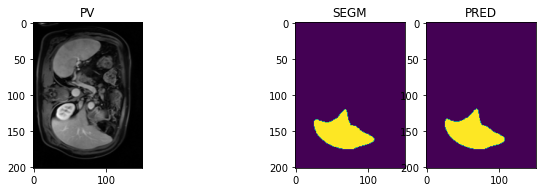

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E104332583_T1_PV_REG_segm.nii.gz


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd0e565fd30>
Traceback (most recent call last):
  File "/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd0e565fd30>
Traceback (most recent call last):
  File "/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/mgross/anaconda

torch.Size([2, 220, 165, 144])
torch.Size([1, 220, 165, 144])
torch.Size([1, 2, 220, 165, 144])
0.9743205904960632
34.00147027033897
3.184079637623156
torch.Size([2, 220, 165, 144])
torch.Size([1, 220, 165, 144])


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd0e565fd30>
Traceback (most recent call last):
  File "/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd0e565fd30>
Traceback (most recent call last):
  File "/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/mgross/anaconda

torch.Size([1, 2, 220, 165, 144])
0.981168270111084
1.0
0.35780264443555476
torch.Size([1, 2, 220, 165, 144])
torch.Size([1, 220, 165, 144])


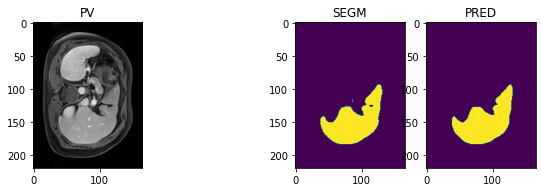

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E101547088_T1_PV_REG_segm.nii.gz
torch.Size([2, 195, 147, 139])
torch.Size([1, 195, 147, 139])
torch.Size([1, 2, 195, 147, 139])
0.9721502065658569
52.85781361385553
3.772033471904945
torch.Size([2, 195, 147, 139])
torch.Size([1, 195, 147, 139])
torch.Size([1, 2, 195, 147, 139])
0.9768095016479492
1.0
0.38130695402401726
torch.Size([1, 2, 195, 147, 139])


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd0e565fd30>
Traceback (most recent call last):
  File "/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd0e565fd30>
Traceback (most recent call last):
  File "/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/mgross/anaconda

torch.Size([1, 195, 147, 139])


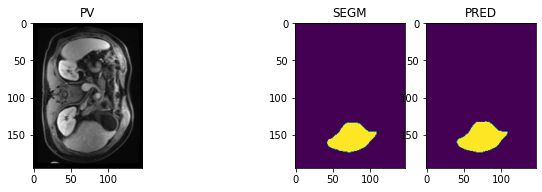

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/11524268_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 155, 132])
torch.Size([1, 190, 155, 132])
torch.Size([1, 2, 190, 155, 132])
0.9640060663223267
50.724747411889595
4.4908406492934425
torch.Size([2, 190, 155, 132])
torch.Size([1, 190, 155, 132])
torch.Size([1, 2, 190, 155, 132])
0.970891535282135
1.4142135623730951
0.437142080722105
torch.Size([1, 2, 190, 155, 132])
torch.Size([1, 190, 155, 132])


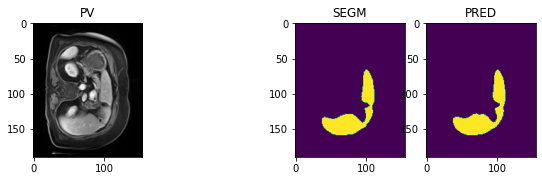

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E106458466_T1_PV_REG_segm.nii.gz
torch.Size([2, 197, 160, 96])
torch.Size([1, 197, 160, 96])
torch.Size([1, 2, 197, 160, 96])
0.9328435063362122
90.51242920048568
20.16762305907528
torch.Size([2, 197, 160, 96])
torch.Size([1, 197, 160, 96])
torch.Size([1, 2, 197, 160, 96])
0.9578056335449219
2.0
0.5934281266485162
torch.Size([1, 2, 197, 160, 96])
torch.Size([1, 197, 160, 96])


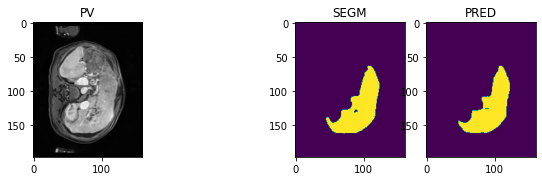

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E107235152_T1_PV_REG_segm.nii.gz
torch.Size([2, 201, 201, 123])
torch.Size([1, 201, 201, 123])
torch.Size([1, 2, 201, 201, 123])
0.9545807838439941
41.06214767694823
3.7841162771842956
torch.Size([2, 201, 201, 123])
torch.Size([1, 201, 201, 123])
torch.Size([1, 2, 201, 201, 123])
0.9659247994422913
1.4142135623730951
0.5517572629377846
torch.Size([1, 2, 201, 201, 123])
torch.Size([1, 201, 201, 123])


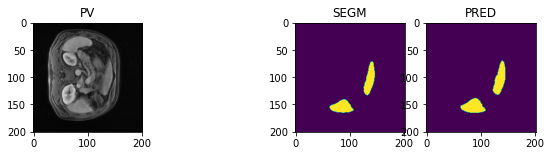

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E105198762_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 164, 144])
torch.Size([1, 190, 164, 144])
torch.Size([1, 2, 190, 164, 144])
0.8682562112808228
68.18357573492314
7.97550498400411
torch.Size([2, 190, 164, 144])
torch.Size([1, 190, 164, 144])
torch.Size([1, 2, 190, 164, 144])
0.8842237591743469
10.246950765959598
1.8499292591581111
torch.Size([1, 2, 190, 164, 144])
torch.Size([1, 190, 164, 144])


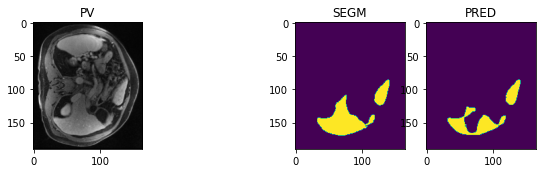

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/11148247_T1_PV_REG_segm.nii.gz
torch.Size([2, 196, 192, 120])
torch.Size([1, 196, 192, 120])
torch.Size([1, 2, 196, 192, 120])
0.9688313603401184
5.0990195135927845
3.187653875858867
torch.Size([2, 196, 192, 120])
torch.Size([1, 196, 192, 120])
torch.Size([1, 2, 196, 192, 120])
0.9748964905738831
1.4142135623730951
0.45785449938315587
torch.Size([1, 2, 196, 192, 120])
torch.Size([1, 196, 192, 120])


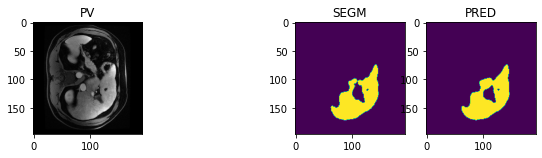

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E106751045_T1_PV_REG_segm.nii.gz
torch.Size([2, 186, 186, 92])
torch.Size([1, 186, 186, 92])
torch.Size([1, 2, 186, 186, 92])
0.9573637247085571
2.23606797749979
0.7226947512630768
torch.Size([2, 186, 186, 92])
torch.Size([1, 186, 186, 92])
torch.Size([1, 2, 186, 186, 92])
0.9574747085571289
2.23606797749979
0.5804230260958851
torch.Size([1, 2, 186, 186, 92])
torch.Size([1, 186, 186, 92])


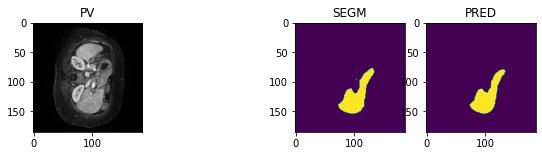

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/9648994_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 148, 142])
torch.Size([1, 190, 148, 142])
torch.Size([1, 2, 190, 148, 142])
0.9648078083992004
77.64663547121665
5.714903207587934
torch.Size([2, 190, 148, 142])
torch.Size([1, 190, 148, 142])
torch.Size([1, 2, 190, 148, 142])
0.9755406975746155
1.4142135623730951
0.4325354804930354
torch.Size([1, 2, 190, 148, 142])
torch.Size([1, 190, 148, 142])


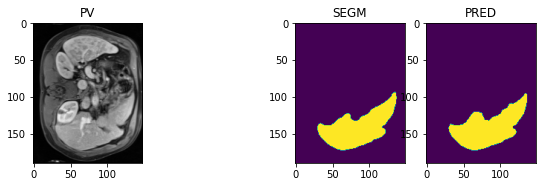

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E102928841_T1_PV_REG_segm.nii.gz
torch.Size([2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
torch.Size([1, 2, 201, 151, 120])
0.977698028087616
1.0
0.38523821414777354
torch.Size([2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
torch.Size([1, 2, 201, 151, 120])
0.977698028087616
1.0
0.38523821414777354
torch.Size([1, 2, 201, 151, 120])
torch.Size([1, 201, 151, 120])


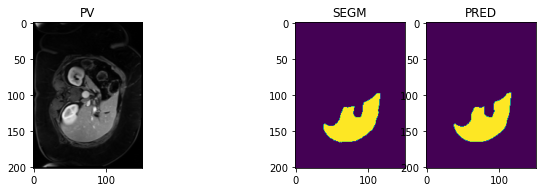

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E105426183_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 163, 116])
torch.Size([1, 200, 163, 116])
torch.Size([1, 2, 200, 163, 116])
0.956795871257782
57.8065715360012
6.336335935129319
torch.Size([2, 200, 163, 116])
torch.Size([1, 200, 163, 116])
torch.Size([1, 2, 200, 163, 116])
0.9779819250106812
1.4142135623730951
0.39790088847684096
torch.Size([1, 2, 200, 163, 116])
torch.Size([1, 200, 163, 116])


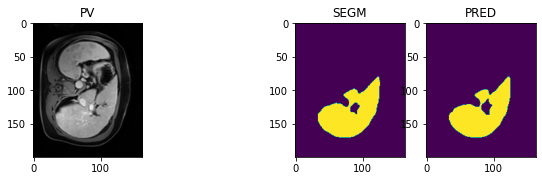

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E100142484_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 155, 132])
torch.Size([1, 190, 155, 132])
torch.Size([1, 2, 190, 155, 132])
0.9794746041297913
1.4142135623730951
0.43524260939484954
torch.Size([2, 190, 155, 132])
torch.Size([1, 190, 155, 132])
torch.Size([1, 2, 190, 155, 132])
0.9794746041297913
1.4142135623730951
0.43524260939484954
torch.Size([1, 2, 190, 155, 132])
torch.Size([1, 190, 155, 132])


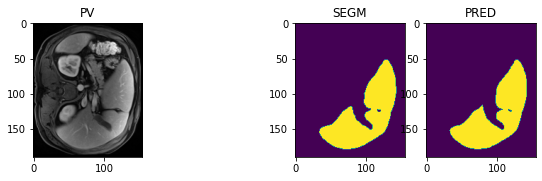

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E105829099_T1_PV_REG_segm.nii.gz
torch.Size([2, 201, 201, 92])
torch.Size([1, 201, 201, 92])
torch.Size([1, 2, 201, 201, 92])
0.9280177354812622
6.4031242374328485
2.660332412074328
torch.Size([2, 201, 201, 92])
torch.Size([1, 201, 201, 92])
torch.Size([1, 2, 201, 201, 92])
0.9312692284584045
3.605551275463989
1.0275755894666574
torch.Size([1, 2, 201, 201, 92])
torch.Size([1, 201, 201, 92])


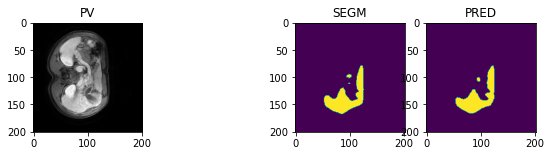

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/9586289_T1_PV_REG_segm.nii.gz
torch.Size([2, 170, 133, 108])
torch.Size([1, 170, 133, 108])
torch.Size([1, 2, 170, 133, 108])
0.7739898562431335
42.127778987158024
10.519397249531055
torch.Size([2, 170, 133, 108])
torch.Size([1, 170, 133, 108])
torch.Size([1, 2, 170, 133, 108])
0.7742236256599426
41.78516483155236
10.322395880835835
torch.Size([1, 2, 170, 133, 108])
torch.Size([1, 170, 133, 108])


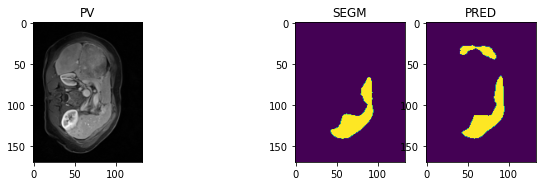

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E107156072_T1_PV_REG_segm.nii.gz
torch.Size([2, 220, 174, 108])
torch.Size([1, 220, 174, 108])
torch.Size([1, 2, 220, 174, 108])
0.975690484046936
2.0
3.1960228518686993
torch.Size([2, 220, 174, 108])
torch.Size([1, 220, 174, 108])
torch.Size([1, 2, 220, 174, 108])
0.9800517559051514
1.4142135623730951
0.34429030021613444
torch.Size([1, 2, 220, 174, 108])
torch.Size([1, 220, 174, 108])


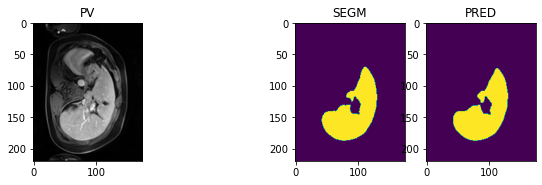

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E104998309_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 173, 120])
torch.Size([1, 200, 173, 120])
torch.Size([1, 2, 200, 173, 120])
0.922150194644928
67.49074010558782
12.497698172218913
torch.Size([2, 200, 173, 120])
torch.Size([1, 200, 173, 120])
torch.Size([1, 2, 200, 173, 120])
0.9772670269012451
1.4142135623730951
0.4428140750946231
torch.Size([1, 2, 200, 173, 120])
torch.Size([1, 200, 173, 120])


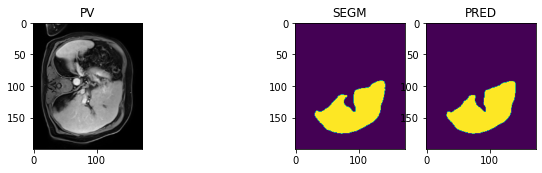

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E105615985_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 149, 132])
torch.Size([1, 190, 149, 132])
torch.Size([1, 2, 190, 149, 132])
0.9751936197280884
1.4142135623730951
0.4253679862541928
torch.Size([2, 190, 149, 132])
torch.Size([1, 190, 149, 132])
torch.Size([1, 2, 190, 149, 132])
0.9751936197280884
1.4142135623730951
0.4253679862541928
torch.Size([1, 2, 190, 149, 132])
torch.Size([1, 190, 149, 132])


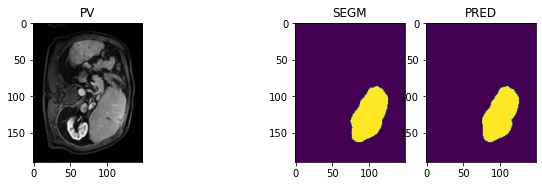

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/12916368_T1_PV_REG_segm.nii.gz
torch.Size([2, 211, 181, 116])
torch.Size([1, 211, 181, 116])
torch.Size([1, 2, 211, 181, 116])
0.9741230010986328
72.89718787443039
4.713437599362497
torch.Size([2, 211, 181, 116])
torch.Size([1, 211, 181, 116])
torch.Size([1, 2, 211, 181, 116])
0.9800047874450684
1.4142135623730951
0.4415157764715052
torch.Size([1, 2, 211, 181, 116])
torch.Size([1, 211, 181, 116])


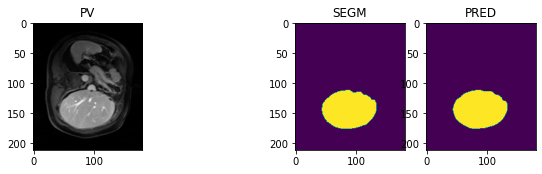

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E103814356_T1_PV_REG_segm.nii.gz
torch.Size([2, 170, 144, 150])
torch.Size([1, 170, 144, 150])
torch.Size([1, 2, 170, 144, 150])
0.9170107245445251
7.3484692283495345
1.4941654499423715
torch.Size([2, 170, 144, 150])
torch.Size([1, 170, 144, 150])
torch.Size([1, 2, 170, 144, 150])
0.9171150922775269
7.3484692283495345
1.3545235461205212
torch.Size([1, 2, 170, 144, 150])
torch.Size([1, 170, 144, 150])


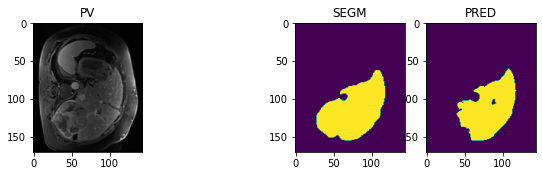

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/11022925_T1_PV_REG_segm.nii.gz
torch.Size([2, 206, 206, 110])
torch.Size([1, 206, 206, 110])
torch.Size([1, 2, 206, 206, 110])
0.9348405003547668
77.42092740338364
13.432466756038295
torch.Size([2, 206, 206, 110])
torch.Size([1, 206, 206, 110])
torch.Size([1, 2, 206, 206, 110])
0.9691401720046997
1.4142135623730951
0.48485980560784425
torch.Size([1, 2, 206, 206, 110])
torch.Size([1, 206, 206, 110])


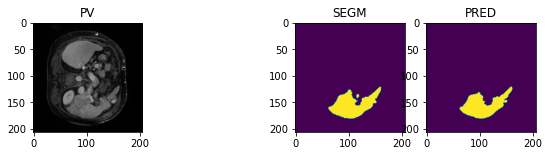

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E106533478_T1_PV_REG_segm.nii.gz
torch.Size([2, 191, 143, 132])
torch.Size([1, 191, 143, 132])
torch.Size([1, 2, 191, 143, 132])
0.9711331725120544
1.4142135623730951
0.423789575179293
torch.Size([2, 191, 143, 132])
torch.Size([1, 191, 143, 132])
torch.Size([1, 2, 191, 143, 132])
0.9711331725120544
1.4142135623730951
0.423789575179293
torch.Size([1, 2, 191, 143, 132])
torch.Size([1, 191, 143, 132])


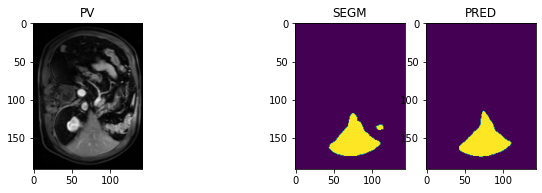

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E106851724_T1_PV_REG_segm.nii.gz
torch.Size([2, 181, 181, 135])
torch.Size([1, 181, 181, 135])
torch.Size([1, 2, 181, 181, 135])
0.9251594543457031
57.87400091653312
9.41381088721315
torch.Size([2, 181, 181, 135])
torch.Size([1, 181, 181, 135])
torch.Size([1, 2, 181, 181, 135])
0.96073317527771
2.23606797749979
0.6262058305795951
torch.Size([1, 2, 181, 181, 135])
torch.Size([1, 181, 181, 135])


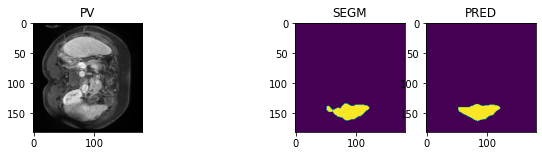

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E103511968_T1_PV_REG_segm.nii.gz
torch.Size([2, 215, 173, 120])
torch.Size([1, 215, 173, 120])
torch.Size([1, 2, 215, 173, 120])
0.9530556201934814
56.16938667993447
5.655407290006288
torch.Size([2, 215, 173, 120])
torch.Size([1, 215, 173, 120])
torch.Size([1, 2, 215, 173, 120])
0.9746522903442383
1.0
0.4160067199533937
torch.Size([1, 2, 215, 173, 120])
torch.Size([1, 215, 173, 120])


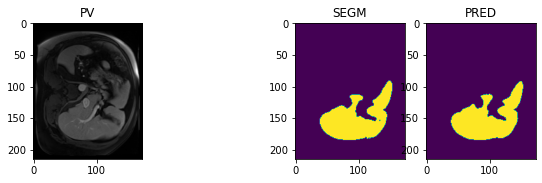

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E107553107_T1_PV_REG_segm.nii.gz
torch.Size([2, 201, 151, 111])
torch.Size([1, 201, 151, 111])
torch.Size([1, 2, 201, 151, 111])
0.9683021903038025
1.7320508075688772
0.4376573855101507
torch.Size([2, 201, 151, 111])
torch.Size([1, 201, 151, 111])
torch.Size([1, 2, 201, 151, 111])
0.9683021903038025
1.7320508075688772
0.4376573855101507
torch.Size([1, 2, 201, 151, 111])
torch.Size([1, 201, 151, 111])


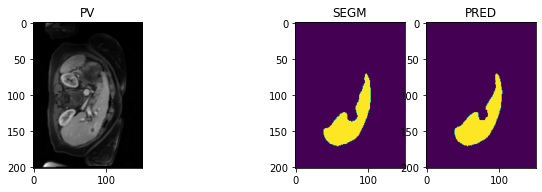

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E100588448_T1_PV_REG_segm.nii.gz
torch.Size([2, 236, 232, 120])
torch.Size([1, 236, 232, 120])
torch.Size([1, 2, 236, 232, 120])
0.9750010967254639
1.7320508075688772
0.5933709259683495
torch.Size([2, 236, 232, 120])
torch.Size([1, 236, 232, 120])
torch.Size([1, 2, 236, 232, 120])
0.9750519394874573
1.7320508075688772
0.49989531664597747
torch.Size([1, 2, 236, 232, 120])
torch.Size([1, 236, 232, 120])


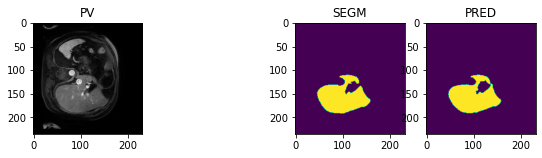

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E104134228_T1_PV_REG_segm.nii.gz
torch.Size([2, 211, 211, 110])
torch.Size([1, 211, 211, 110])
torch.Size([1, 2, 211, 211, 110])
0.9615141153335571
54.71745608121781
5.817314538162236
torch.Size([2, 211, 211, 110])
torch.Size([1, 211, 211, 110])
torch.Size([1, 2, 211, 211, 110])
0.9689013957977295
1.4142135623730951
0.4747667238689685
torch.Size([1, 2, 211, 211, 110])
torch.Size([1, 211, 211, 110])


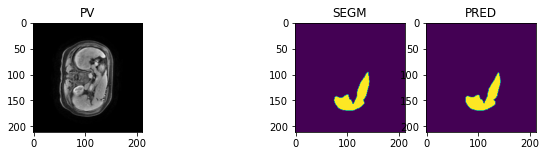

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E101686218_T1_PV_REG_segm.nii.gz
torch.Size([2, 210, 181, 108])
torch.Size([1, 210, 181, 108])
torch.Size([1, 2, 210, 181, 108])
0.9586740732192993
86.3075894692929
8.318824205949722
torch.Size([2, 210, 181, 108])
torch.Size([1, 210, 181, 108])
torch.Size([1, 2, 210, 181, 108])
0.9714469909667969
2.0
0.5907754729516314
torch.Size([1, 2, 210, 181, 108])
torch.Size([1, 210, 181, 108])


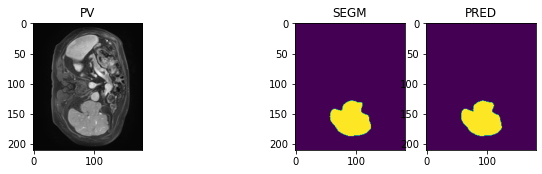

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E100967188_T1_PV_REG_segm.nii.gz
torch.Size([2, 225, 181, 131])
torch.Size([1, 225, 181, 131])
torch.Size([1, 2, 225, 181, 131])
0.9744497537612915
1.4142135623730951
2.350773185053129
torch.Size([2, 225, 181, 131])
torch.Size([1, 225, 181, 131])
torch.Size([1, 2, 225, 181, 131])
0.9783936738967896
1.4142135623730951
0.4130044688773169
torch.Size([1, 2, 225, 181, 131])
torch.Size([1, 225, 181, 131])


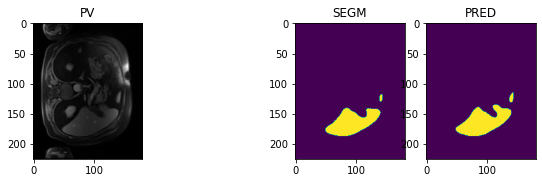

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E107476766_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 161, 115])
torch.Size([1, 200, 161, 115])
torch.Size([1, 2, 200, 161, 115])
0.9288445711135864
64.16657997888781
9.703910551705874
torch.Size([2, 200, 161, 115])
torch.Size([1, 200, 161, 115])
torch.Size([1, 2, 200, 161, 115])
0.9604781866073608
1.4142135623730951
0.48197380913027044
torch.Size([1, 2, 200, 161, 115])
torch.Size([1, 200, 161, 115])


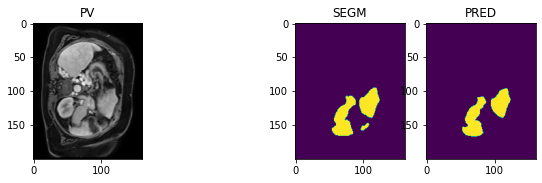

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E104250009_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 156, 132])
torch.Size([1, 200, 156, 132])
torch.Size([1, 2, 200, 156, 132])
0.9615733027458191
62.9690399666857
6.649380793089617
torch.Size([2, 200, 156, 132])
torch.Size([1, 200, 156, 132])
torch.Size([1, 2, 200, 156, 132])
0.9796163439750671
1.0
0.36505141359578047
torch.Size([1, 2, 200, 156, 132])
torch.Size([1, 200, 156, 132])


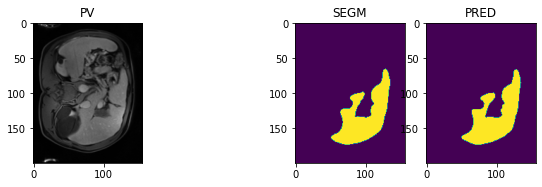

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E105152299_T1_PV_REG_segm.nii.gz
torch.Size([2, 192, 192, 108])
torch.Size([1, 192, 192, 108])
torch.Size([1, 2, 192, 192, 108])
0.7101904153823853
70.26663495463619
21.006605895497483
torch.Size([2, 192, 192, 108])
torch.Size([1, 192, 192, 108])
torch.Size([1, 2, 192, 192, 108])
0.9684737324714661
1.4142135623730951
0.45517918011475894
torch.Size([1, 2, 192, 192, 108])
torch.Size([1, 192, 192, 108])


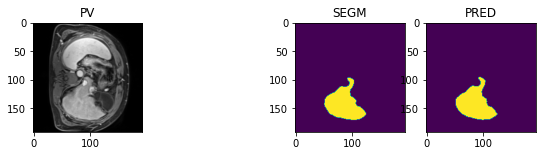

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/11308203_T1_PV_REG_segm.nii.gz
torch.Size([2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
torch.Size([1, 2, 201, 151, 120])
0.9785811901092529
1.4142135623730951
0.3903969430040594
torch.Size([2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
torch.Size([1, 2, 201, 151, 120])
0.9785811901092529
1.4142135623730951
0.3903969430040594
torch.Size([1, 2, 201, 151, 120])
torch.Size([1, 201, 151, 120])


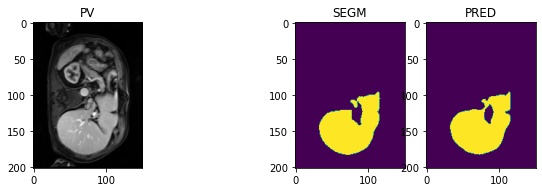

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E107046127_T1_PV_REG_segm.nii.gz
torch.Size([2, 230, 180, 120])
torch.Size([1, 230, 180, 120])
torch.Size([1, 2, 230, 180, 120])
0.9630374312400818
1.7320508075688772
0.49571536906243063
torch.Size([2, 230, 180, 120])
torch.Size([1, 230, 180, 120])
torch.Size([1, 2, 230, 180, 120])
0.9630374312400818
1.7320508075688772
0.49571536906243063
torch.Size([1, 2, 230, 180, 120])
torch.Size([1, 230, 180, 120])


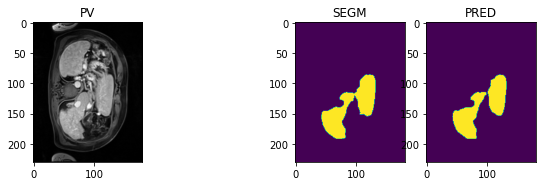

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/13106408_T1_PV_REG_segm.nii.gz
torch.Size([2, 210, 158, 120])
torch.Size([1, 210, 158, 120])
torch.Size([1, 2, 210, 158, 120])
0.9690073132514954
1.4142135623730951
0.5069529690545483
torch.Size([2, 210, 158, 120])
torch.Size([1, 210, 158, 120])
torch.Size([1, 2, 210, 158, 120])
0.9691348075866699
1.4142135623730951
0.40462654139989396
torch.Size([1, 2, 210, 158, 120])
torch.Size([1, 210, 158, 120])


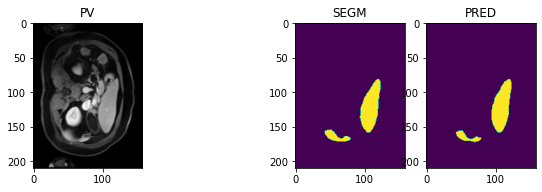

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E102486953_T1_PV_REG_segm.nii.gz
torch.Size([2, 170, 149, 120])
torch.Size([1, 170, 149, 120])
torch.Size([1, 2, 170, 149, 120])
0.6898117661476135
55.14526271584895
17.052818350981024
torch.Size([2, 170, 149, 120])
torch.Size([1, 170, 149, 120])
torch.Size([1, 2, 170, 149, 120])
0.9479461908340454
3.0
0.6954384179632448
torch.Size([1, 2, 170, 149, 120])
torch.Size([1, 170, 149, 120])


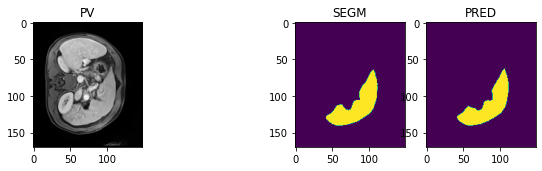

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E101055640_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 137, 120])
torch.Size([1, 200, 137, 120])
torch.Size([1, 2, 200, 137, 120])
0.9608720541000366
9.219544457292887
0.5016143360723557
torch.Size([2, 200, 137, 120])
torch.Size([1, 200, 137, 120])
torch.Size([1, 2, 200, 137, 120])
0.9608720541000366
9.219544457292887
0.5016143360723557
torch.Size([1, 2, 200, 137, 120])
torch.Size([1, 200, 137, 120])


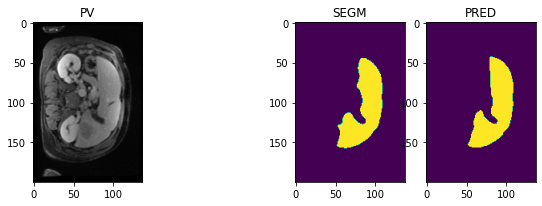

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/10807315_T1_PV_REG_segm.nii.gz
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9340970516204834
65.49045732013177
11.148481686081327
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9757218956947327
1.4142135623730951
0.3892290270392317
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


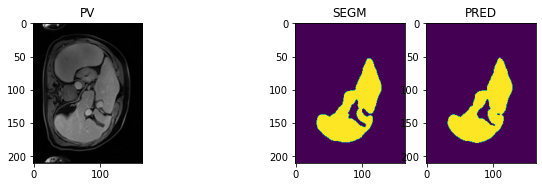

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/13170972_T1_PV_REG_segm.nii.gz
torch.Size([2, 205, 154, 155])
torch.Size([1, 205, 154, 155])
torch.Size([1, 2, 205, 154, 155])
0.920454204082489
78.8986691902975
9.424761787921815
torch.Size([2, 205, 154, 155])
torch.Size([1, 205, 154, 155])
torch.Size([1, 2, 205, 154, 155])
0.9408024549484253
5.477225575051661
1.2317660527298813
torch.Size([1, 2, 205, 154, 155])
torch.Size([1, 205, 154, 155])


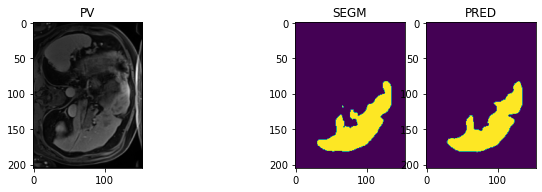

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E104594843_T1_PV_REG_segm.nii.gz
torch.Size([2, 231, 231, 144])
torch.Size([1, 231, 231, 144])
torch.Size([1, 2, 231, 231, 144])
0.9751837849617004
1.4142135623730951
1.234195694623747
torch.Size([2, 231, 231, 144])
torch.Size([1, 231, 231, 144])
torch.Size([1, 2, 231, 231, 144])
0.9759039282798767
1.4142135623730951
0.48146481163686006
torch.Size([1, 2, 231, 231, 144])
torch.Size([1, 231, 231, 144])


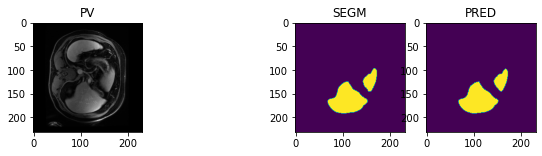

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E104034609_T1_PV_REG_segm.nii.gz
torch.Size([2, 191, 141, 120])
torch.Size([1, 191, 141, 120])
torch.Size([1, 2, 191, 141, 120])
0.9345930814743042
76.1409875778302
14.731302899236873
torch.Size([2, 191, 141, 120])
torch.Size([1, 191, 141, 120])
torch.Size([1, 2, 191, 141, 120])
0.9787772297859192
1.0
0.3742637444203817
torch.Size([1, 2, 191, 141, 120])
torch.Size([1, 191, 141, 120])


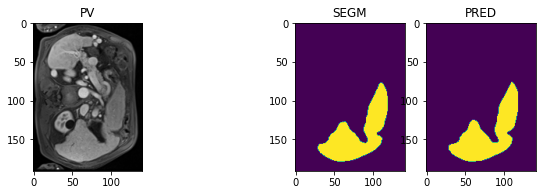

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E107774979_T1_PV_REG_segm.nii.gz
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9710749387741089
1.4142135623730951
1.287430167399125
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9726567268371582
1.4142135623730951
0.3920401538363594
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


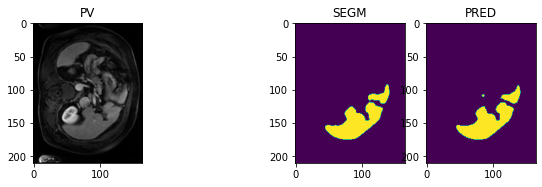

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E104900599_T1_PV_REG_segm.nii.gz
torch.Size([2, 230, 180, 142])
torch.Size([1, 230, 180, 142])
torch.Size([1, 2, 230, 180, 142])
0.9504258036613464
62.61269827673074
8.12624185576179
torch.Size([2, 230, 180, 142])
torch.Size([1, 230, 180, 142])
torch.Size([1, 2, 230, 180, 142])
0.9761438369750977
1.4142135623730951
0.40170527434871367
torch.Size([1, 2, 230, 180, 142])
torch.Size([1, 230, 180, 142])


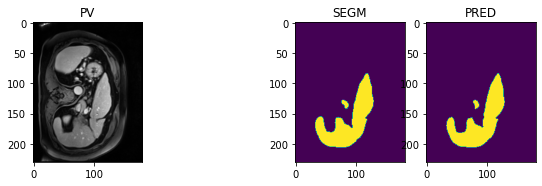

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E104657225_T1_PV_REG_segm.nii.gz
torch.Size([2, 180, 135, 108])
torch.Size([1, 180, 135, 108])
torch.Size([1, 2, 180, 135, 108])
0.8830908536911011
65.00769185258002
14.731023873601771
torch.Size([2, 180, 135, 108])
torch.Size([1, 180, 135, 108])
torch.Size([1, 2, 180, 135, 108])
0.9693923592567444
2.0
0.5219594140322743
torch.Size([1, 2, 180, 135, 108])
torch.Size([1, 180, 135, 108])


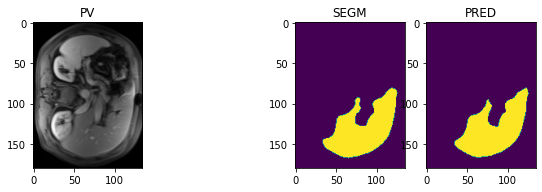

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E105599954_T1_PV_REG_segm.nii.gz
torch.Size([2, 235, 183, 132])
torch.Size([1, 235, 183, 132])
torch.Size([1, 2, 235, 183, 132])
0.9678016901016235
2.0
1.7840821987871023
torch.Size([2, 235, 183, 132])
torch.Size([1, 235, 183, 132])
torch.Size([1, 2, 235, 183, 132])
0.969285249710083
1.7320508075688772
0.5561787371743119
torch.Size([1, 2, 235, 183, 132])
torch.Size([1, 235, 183, 132])


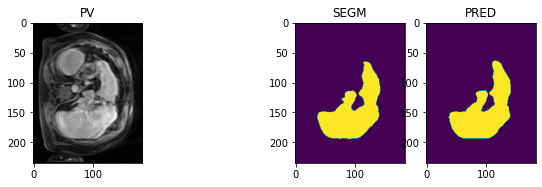

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E103570649_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 156, 127])
torch.Size([1, 200, 156, 127])
torch.Size([1, 2, 200, 156, 127])
0.9272947311401367
40.7308237088326
6.435131788822026
torch.Size([2, 200, 156, 127])
torch.Size([1, 200, 156, 127])
torch.Size([1, 2, 200, 156, 127])
0.9696537852287292
1.4142135623730951
0.482603264270047
torch.Size([1, 2, 200, 156, 127])
torch.Size([1, 200, 156, 127])


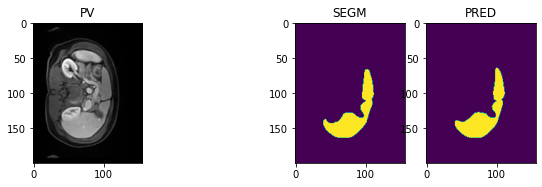

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E105504009_T1_PV_REG_segm.nii.gz
torch.Size([2, 211, 152, 104])
torch.Size([1, 211, 152, 104])
torch.Size([1, 2, 211, 152, 104])
0.9688500761985779
45.16635916254486
3.363390569874413
torch.Size([2, 211, 152, 104])
torch.Size([1, 211, 152, 104])
torch.Size([1, 2, 211, 152, 104])
0.9759612083435059
1.4142135623730951
0.43170151020231107
torch.Size([1, 2, 211, 152, 104])
torch.Size([1, 211, 152, 104])


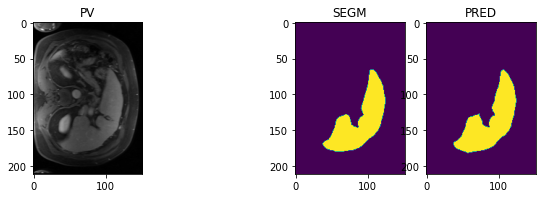

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E103831361_T1_PV_REG_segm.nii.gz
torch.Size([2, 221, 221, 119])
torch.Size([1, 221, 221, 119])
torch.Size([1, 2, 221, 221, 119])
0.9177420139312744
76.11832893594026
15.621973852677185
torch.Size([2, 221, 221, 119])
torch.Size([1, 221, 221, 119])
torch.Size([1, 2, 221, 221, 119])
0.9722798466682434
1.7320508075688772
0.48016477060334656
torch.Size([1, 2, 221, 221, 119])
torch.Size([1, 221, 221, 119])


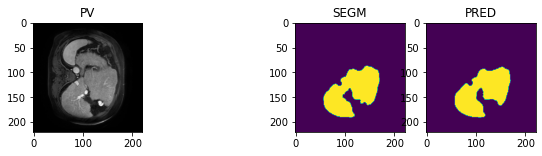

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/10843891_T1_PV_REG_segm.nii.gz
torch.Size([2, 175, 137, 120])
torch.Size([1, 175, 137, 120])
torch.Size([1, 2, 175, 137, 120])
0.9732330441474915
1.4142135623730951
0.9311945470685804
torch.Size([2, 175, 137, 120])
torch.Size([1, 175, 137, 120])
torch.Size([1, 2, 175, 137, 120])
0.9734610319137573
1.4142135623730951
0.4871348515477154
torch.Size([1, 2, 175, 137, 120])
torch.Size([1, 175, 137, 120])


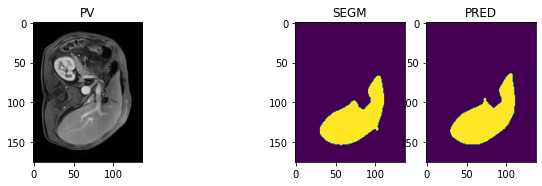

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E101762106_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.8825449347496033
76.27679844903703
20.808372690739063
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.970164954662323
1.4142135623730951
0.44613498823735004
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


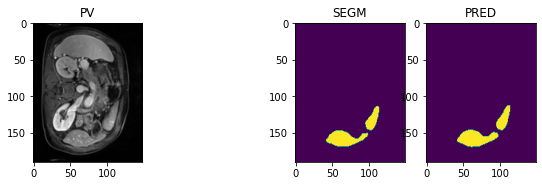

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/12543786_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.9600450396537781
1.7320508075688772
0.5790506237232618
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.9600450396537781
1.7320508075688772
0.5790506237232618
torch.Size([1, 2, 200, 163, 120])
torch.Size([1, 200, 163, 120])


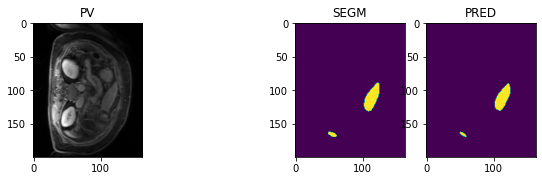

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E107077373_T1_PV_REG_segm.nii.gz
torch.Size([2, 220, 172, 120])
torch.Size([1, 220, 172, 120])
torch.Size([1, 2, 220, 172, 120])
0.9754998683929443
1.4142135623730951
0.40757960193354476
torch.Size([2, 220, 172, 120])
torch.Size([1, 220, 172, 120])
torch.Size([1, 2, 220, 172, 120])
0.9754998683929443
1.4142135623730951
0.40757960193354476
torch.Size([1, 2, 220, 172, 120])
torch.Size([1, 220, 172, 120])


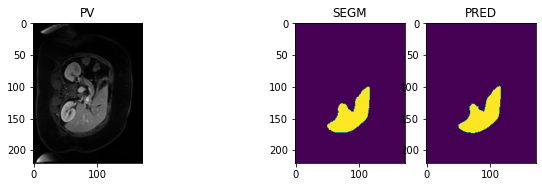

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/E106501028_T1_PV_REG_segm.nii.gz
[0.9713834524154663, 0.9620359539985657, 0.950715184211731, 0.8582643270492554, 0.955176830291748, 0.9629046320915222, 0.9789929986000061, 0.9657390713691711, 0.9170084595680237, 0.857477605342865, 0.9613134264945984, 0.9600239992141724, 0.8037298321723938, 0.9282627105712891, 0.9712070226669312, 0.9598252177238464, 0.9666485786437988, 0.9782244563102722, 0.860634446144104, 0.9525139927864075, 0.956264853477478, 0.9268923997879028, 0.7992457151412964, 0.9139358997344971, 0.9686031341552734, 0.9387735724449158, 0.974003255367279, 0.965411365032196, 0.971438467502594, 0.9796627759933472, 0.9476144313812256, 0.9707602262496948, 0.9423151016235352, 0.9675701260566711, 0.9765977263450623, 0.9709125757217407, 0.9511988162994385, 0.9743205904960632, 0.9721502065658569, 0.9640060663223267, 0.9328435063362122, 0.9545807838439941, 0.8682562112808228, 0.9688313603401184, 0.9573

,DICE,POST_DICE,HD95,POST_HD95,InferenceTime,AUTOMATED-LIVER-SEGM,EXPERIMENT_ID
0,0.971383,0.972255,1.414214,1.414214,0.010554,/tensor5/data1/mgross/Liver/studies/Contrast-N...,2mpMRI-Contrast-Imaging
1,0.962036,0.976184,59.000847,1.414214,0.005441,/tensor5/data1/mgross/Liver/studies/Contrast-N...,2mpMRI-Contrast-Imaging
2,0.950715,0.970981,39.812058,1.414214,0.008498,/tensor5/data1/mgross/Liver/studies/Contrast-N...,2mpMRI-Contrast-Imaging
3,0.858264,0.976471,75.710964,1.000000,0.027275,/tensor5/data1/mgross/Liver/studies/Contrast-N...,2mpMRI-Contrast-Imaging
4,0.955177,0.963524,57.801384,2.000000,0.004437,/tensor5/data1/mgross/Liver/studies/Contrast-N...,2mpMRI-Contrast-Imaging


In [107]:
roi_size = (224, 224, 128)

df_test_results = run_inference_and_evaluate(
        model=model, 
        data_loader= test_loader, 
        roi_size=roi_size, 
        plot_images=True, 
        save_output=True,
    output_path= OUTPUT_PATH)
    #max_eval = 2)


torch.cuda.empty_cache()
df_test_results['EXPERIMENT_ID'] = '2mpMRI-Contrast-Imaging'
df_test_results.head()

In [109]:
df_test_results.to_csv('../Results/Results-2mpMRI-Net.csv')

## External Testing

In [22]:
from monai.data import Dataset, DataLoader, pad_list_data_collate

def compute_evaluation_metrics(y_pred, y, keep=False):
    
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    hd = monai.metrics.HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95, get_not_nans=False)
    mad = monai.metrics.SurfaceDistanceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep_largest = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    dice_list = list()
    hd_list = list()
    mad_list = list()
    for y_pred_i, y_i in decollate_batch((y_pred, y)):
        print(y_pred_i.shape)
        print(y_i.shape)
        if keep:
            #dice(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #hd(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #mad(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            y_pred_i_proc=one_hot(keep_largest(argmax(y_pred_i)))
        else:
                
            # Calculate Dice on the raw output
            #dice(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #hd(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #mad(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            y_pred_i_proc = one_hot(argmax(y_pred_i))
        y_pred_i_proc = monai.transforms.AddChannel()(y_pred_i_proc)
        y_i_proc = monai.transforms.AddChannel()(one_hot(y_i))
        print(y_pred_i_proc.shape)
            
        #dice(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #hd(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #mad(y_pred=y_pred_i_proc, y=one_hot(y_i))
            
        dice(y_pred=y_pred_i_proc, y=y_i_proc)
        hd(y_pred=y_pred_i_proc, y=y_i_proc)
        mad(y_pred=y_pred_i_proc, y=y_i_proc)
        
        dice_value = dice.aggregate().item()
        hd_value = hd.aggregate().item()
        mad_value = mad.aggregate().item()
        
        print(dice_value)
        print(hd_value)
        print(mad_value)
        
        dice_list.append(dice_value)
        hd_list.append(hd_value)
        mad_list.append(mad_value)
              
    return dice_list, hd_list, mad_list


def run_inference_and_evaluate(model, data_loader, plot_images=False, max_eval=None, 
                               save_output=False,roi_size=(224,224,128), sw_batch_size=4, output_path=None):
    
    """Inference and evaluation function for Liver segmentation.
    
    """   
    
    df_eval = pd.DataFrame()
    
    acc_ids = list()
    input_paths = list()
    output_paths = list()
    
    original_dice_results = list()
    postprocess_dice_results = list()

    original_hd_results = list()
    postprocess_hd_results = list()

    original_mad_results = list()
    postprocess_mad_results = list()
    
    inference_times = list()
    


    
    # Use MONAI one_hot transform
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    with torch.no_grad():
        for i, test_data in tqdm(enumerate(data_loader)):
        # Early stopping
            if max_eval is not None:
                if i>=max_eval:
                    break

            #print(test_data['ACCESSION_ID'][0])
            #for val in test_data['ACCESSION_ID'][0]:
            #    acc_ids.append(val)

    
            art_images =  test_data["ART"].to(device)
            pv_images =  test_data["PV"].to(device)
            
            
            x = torch.cat((art_images, pv_images) ,dim=1)
            y = test_data['SEGM'].cpu()




            start_time = time.time()
            y_pred = sliding_window_inference(x, roi_size, sw_batch_size, model)
            stop_time = time.time()

            inference_time = stop_time-start_time
            inference_times.append(inference_time)

            x = x.detach().cpu()
            y_pred = y_pred.detach().cpu()
            #print(y_pred.shape)

            #argmax = torch.argmax(y_pred, dim=1, keepdim=True)
            #argmax = argmax.detach().cpu()

            #y_onehot = one_hot(y)
            #y_pred_onehot = one_hot(argmax)

            # Evaluate segmentation metrics
            eval_list = list()
            # Update to MONAI 0.7+
            dice_values, hd_values, mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y
            )

            for val in dice_values:
                original_dice_results.append(val)
            for val in hd_values:
                original_hd_results.append(val)
            for val in mad_values:
                original_mad_results.append(val)



            post_dice_values, post_hd_values, post_mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y, keep=True
            )        #dice_list = list()
            #post_dice_list = list()

            for val in post_dice_values:
                postprocess_dice_results.append(val)
            for val in post_hd_values:
                postprocess_hd_results.append(val)
            for val in post_mad_values:
                postprocess_mad_results.append(val)





            print(y_pred.shape)
            print(argmax(y_pred[0,...]).shape)


            if plot_images:
                art_img = art_images.detach().cpu()
                pv_img = pv_images.detach().cpu()
                


                slice_num = x.shape[-1]//2

                plt.figure('check', (9, 3))
                plt.subplot(1, 4, 1)
                plt.title('ART')
                plt.imshow(art_img[0,0,:,:,slice_num], cmap='gray')

                plt.subplot(1, 4, 2)
                plt.title('PV')
                plt.imshow(pv_img[0,0,:,:,slice_num], cmap='gray')

            
                plt.subplot(1, 4, 3)
                plt.title('SEGM')
                plt.imshow(y[0,0,:,:,slice_num])

                plt.subplot(1, 4, 4)
                plt.title('PRED')
                #plt.imshow(argmax(y_pred[0,...])[0,:,:,slice_num])
                plt.imshow(keep(argmax(y_pred[0,...]))[0,:,:,slice_num])
                plt.show()


            # Write data out
            if save_output:
                # Get the image affine matrix
                current_affine = test_data['art_meta_dict']['affine'][0].numpy()
                original_affine = test_data['art_meta_dict']['original_affine'][0].numpy()
                original_spatial_shape = test_data['art_meta_dict']['spatial_shape'][0].numpy()

                input_file_name = test_data['art_meta_dict']['filename_or_obj'][0]
                output_file_name = os.path.split(input_file_name)[1]
                output_root_name = output_file_name[:-len('.nii.gz')]
                
                
                output_root_name = str(test_data['ACCESSION_ID'][0])
                
                output_path_final = os.path.join(output_path,'{}_segm.nii.gz'.format(output_root_name))
                print('Saving segmentation results: {}'.format(output_path_final))
                
                output_paths.append(output_path_final)
                
                #output_segm = argmax.cpu()[0, 0,...].numpy()
                output_segm = keep(argmax(y_pred[0,...])).cpu()[0,...].numpy()
                write_nifti(output_segm, output_path_final,
                            mode='nearest',
                            affine=current_affine, 
                            target_affine=original_affine,
                            output_spatial_shape=original_spatial_shape, 
                            dtype=np.float32
                           )

    
    #df_eval['ACCESSION_ID'] = acc_ids
    #df_eval['ART'] = input_paths
    df_eval['DICE'] = original_dice_results
    print(original_dice_results)
    df_eval['POST_DICE'] = postprocess_dice_results
    df_eval['HD95'] = original_hd_results
    df_eval['POST_HD95'] = postprocess_hd_results
    #df_eval['MAD'] = original_mad_results
    #df_eval['POST_MAD'] = postprocess_mad_results
    df_eval['InferenceTime'] = inference_times
    if output_path is not None:
        df_eval['AUTOMATED-LIVER-SEGM'] = output_paths    
    return df_eval


In [23]:
import glob 
import pandas as pd

external_testing_img_paths = pd.read_csv('/tensor5/data1/jonofrey/Liver/Paris/registration/nonrigid_nmi/Nonrigid_Registered_NMI_Image_Paths.csv')

included_accs = [1,3, 4, 6, 10, 11, 12, 17, 18, 19, 22, 32, 35, 40, 55, 59]
external_testing_img_paths = external_testing_img_paths[external_testing_img_paths['ACCESSION_ID'].isin(included_accs)]

segm_path = '/tensor5/data1/mgross/Liver/Paris/man_liver_segms/*_PV_LIVER-label.nii.gz'
segm_paths = glob.glob(segm_path)

external_testing_accs = [int(i.split('/')[-1].split('_')[0]) for i in segm_paths]

df_external_testing = pd.DataFrame({'ACCESSION_ID': external_testing_accs, 'SEGM' : segm_paths})
df_external_testing = pd.merge(external_testing_img_paths, df_external_testing, on = 'ACCESSION_ID')

df_external_testing = df_external_testing[['ACCESSION_ID','PV_ART','PV',  'SEGM']]



df_external_testing.rename(columns={'PV_ART' : 'ART',
                                    'LIVER': 'SEGM'}, inplace = True)
df_external_testing.columns

Index(['ACCESSION_ID', 'ART', 'PV', 'SEGM'], dtype='object')

In [24]:
external_test_data_dict = df_external_testing.to_dict('records')
print('Number of external testing files: ', len(external_test_data_dict))

Number of external testing files:  16


In [25]:
external_test_ds = monai.data.PersistentDataset(
    data=external_test_data_dict, transform=test_transforms, cache_dir=CACHE_PATH
)

external_test_loader = DataLoader(external_test_ds, batch_size=1, num_workers=4)

In [26]:
external_test_ds = monai.data.Dataset(
    data=external_test_data_dict, transform=test_transforms)
external_test_loader = DataLoader(external_test_ds, batch_size=1, num_workers=4)

torch.Size([1, 1, 210, 210, 100])
torch.Size([1, 1, 210, 210, 100])
tensor(1)
ART shape: torch.Size([210, 210, 100]), label shape: torch.Size([210, 210, 100])
ART mean: 0.1549057960510254
PV shape: torch.Size([210, 210, 100]), label shape: torch.Size([210, 210, 100])
PV mean: 0.18028146028518677


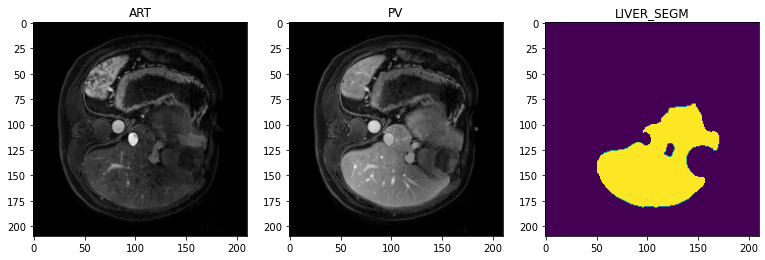

In [27]:
check_ds = monai.data.Dataset(data=external_test_data_dict[:1], transform=test_transforms)


check_loader = DataLoader(check_ds, batch_size=10, num_workers=0, collate_fn=list_data_collate) #pad_list_data_collate, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['ART'].shape)
print(check_data['PV'].shape)


num_display = 10
if check_data['ART'].shape[0] < num_display:
    num_display = check_data['ART'].shape[0]

for i in range(num_display):
    acc_id, ART, PV , liver_label = (check_data['ACCESSION_ID'][i],check_data['ART'][i][0],check_data['PV'][i][0], check_data['SEGM'][i][0])
    print(acc_id)
    
    print('ART shape: {}, label shape: {}'.format(ART.shape, liver_label.shape))
    print('ART mean: {}'.format(np.mean(ART.numpy())))
    
    
    print('PV shape: {}, label shape: {}'.format(PV.shape, liver_label.shape))
    print('PV mean: {}'.format(np.mean(PV.numpy())))
    


    slice_num = ART.shape[2]//2
    
    plt.figure('check', (13, 15))

   
    plt.subplot(1, 3, 1)
    plt.title('ART')
    plt.imshow(ART[:,:,slice_num], cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('PV')
    plt.imshow(PV[:,:,slice_num], cmap='gray')
    

    plt.subplot(1, 3, 3)
    plt.title('LIVER_SEGM')
    plt.imshow(liver_label[:,:,slice_num])
    plt.show()


    


0it [00:00, ?it/s]

torch.Size([2, 210, 210, 100])
torch.Size([1, 210, 210, 100])
torch.Size([1, 2, 210, 210, 100])
0.9641662836074829
2.8284271247461903
0.5570879618992235
torch.Size([2, 210, 210, 100])
torch.Size([1, 210, 210, 100])
torch.Size([1, 2, 210, 210, 100])
0.9641738533973694
2.8284271247461903
0.5536773734611933
torch.Size([1, 2, 210, 210, 100])
torch.Size([1, 210, 210, 100])


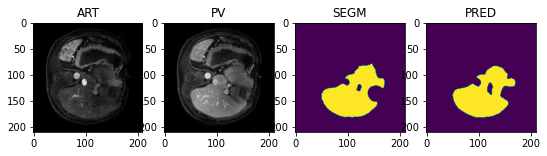

torch.Size([2, 230, 230, 125])
torch.Size([1, 230, 230, 125])
torch.Size([1, 2, 230, 230, 125])
0.9787505865097046
2.0
1.010386371966841
torch.Size([2, 230, 230, 125])
torch.Size([1, 230, 230, 125])
torch.Size([1, 2, 230, 230, 125])
0.9794318675994873
2.0
0.4215519430378379
torch.Size([1, 2, 230, 230, 125])
torch.Size([1, 230, 230, 125])


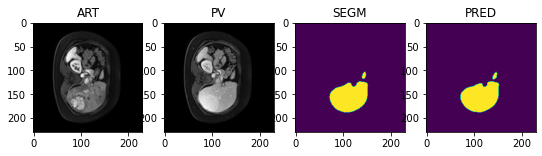

torch.Size([2, 228, 228, 105])
torch.Size([1, 228, 228, 105])
torch.Size([1, 2, 228, 228, 105])
0.9313936829566956
18.027756377319946
3.2660082011521885
torch.Size([2, 228, 228, 105])
torch.Size([1, 228, 228, 105])
torch.Size([1, 2, 228, 228, 105])
0.9357619285583496
3.0
1.2058084469789565
torch.Size([1, 2, 228, 228, 105])
torch.Size([1, 228, 228, 105])


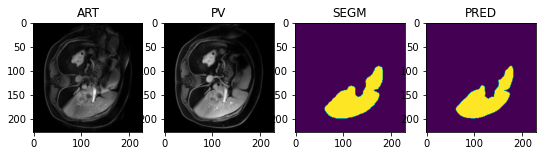

torch.Size([2, 211, 211, 104])
torch.Size([1, 211, 211, 104])
torch.Size([1, 2, 211, 211, 104])
0.9615792036056519
57.78840568541752
7.902649467542354
torch.Size([2, 211, 211, 104])
torch.Size([1, 211, 211, 104])
torch.Size([1, 2, 211, 211, 104])
0.9686428904533386
2.0
0.5790211678460173
torch.Size([1, 2, 211, 211, 104])
torch.Size([1, 211, 211, 104])


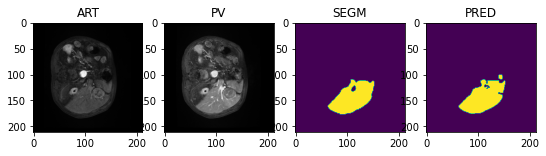

torch.Size([2, 191, 167, 118])
torch.Size([1, 191, 167, 118])
torch.Size([1, 2, 191, 167, 118])
0.7755936980247498
54.48853090330111
12.978102707180842
torch.Size([2, 191, 167, 118])
torch.Size([1, 191, 167, 118])
torch.Size([1, 2, 191, 167, 118])
0.7757248282432556
54.496330053186774
12.990668811552506
torch.Size([1, 2, 191, 167, 118])
torch.Size([1, 191, 167, 118])


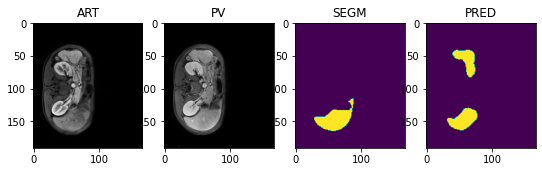

torch.Size([2, 211, 211, 109])
torch.Size([1, 211, 211, 109])
torch.Size([1, 2, 211, 211, 109])
0.8916339874267578
59.508402656802026
13.091115338948681
torch.Size([2, 211, 211, 109])
torch.Size([1, 211, 211, 109])
torch.Size([1, 2, 211, 211, 109])
0.9497030973434448
10.723805294763608
1.8526128154598334
torch.Size([1, 2, 211, 211, 109])
torch.Size([1, 211, 211, 109])


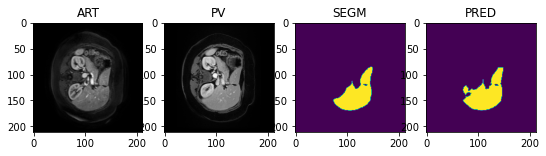

torch.Size([2, 201, 178, 108])
torch.Size([1, 201, 178, 108])
torch.Size([1, 2, 201, 178, 108])
0.9590423703193665
3.0
1.34810822949403
torch.Size([2, 201, 178, 108])
torch.Size([1, 201, 178, 108])
torch.Size([1, 2, 201, 178, 108])
0.9593921899795532
3.0
0.663624854851946
torch.Size([1, 2, 201, 178, 108])
torch.Size([1, 201, 178, 108])


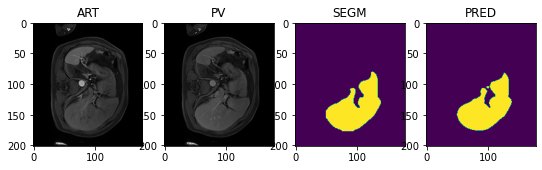

torch.Size([2, 204, 204, 100])
torch.Size([1, 204, 204, 100])
torch.Size([1, 2, 204, 204, 100])
0.8939568996429443
8.0
1.852906914506413
torch.Size([2, 204, 204, 100])
torch.Size([1, 204, 204, 100])
torch.Size([1, 2, 204, 204, 100])
0.8946524262428284
7.280109889280518
1.6373838374397962
torch.Size([1, 2, 204, 204, 100])
torch.Size([1, 204, 204, 100])


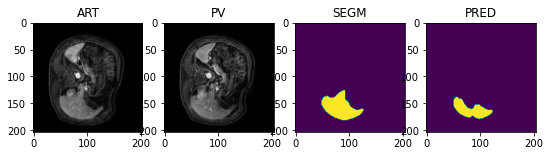

torch.Size([2, 189, 189, 105])
torch.Size([1, 189, 189, 105])
torch.Size([1, 2, 189, 189, 105])
0.90966796875
10.770329614269007
1.9297692776451996
torch.Size([2, 189, 189, 105])
torch.Size([1, 189, 189, 105])
torch.Size([1, 2, 189, 189, 105])
0.9096645712852478
10.756372318417338
1.9286156376780617
torch.Size([1, 2, 189, 189, 105])
torch.Size([1, 189, 189, 105])


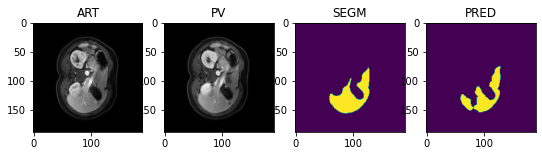

torch.Size([2, 201, 201, 96])
torch.Size([1, 201, 201, 96])
torch.Size([1, 2, 201, 201, 96])
0.8211581707000732
89.47625383307015
32.88624974080879
torch.Size([2, 201, 201, 96])
torch.Size([1, 201, 201, 96])
torch.Size([1, 2, 201, 201, 96])
0.8658252358436584
41.31040987138199
8.269896308223366
torch.Size([1, 2, 201, 201, 96])
torch.Size([1, 201, 201, 96])


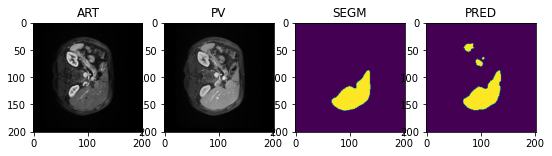

torch.Size([2, 210, 210, 100])
torch.Size([1, 210, 210, 100])
torch.Size([1, 2, 210, 210, 100])
0.894711434841156
8.18535277187245
1.9823704708648036
torch.Size([2, 210, 210, 100])
torch.Size([1, 210, 210, 100])
torch.Size([1, 2, 210, 210, 100])
0.8964037299156189
7.0710678118654755
1.7262340789368158
torch.Size([1, 2, 210, 210, 100])
torch.Size([1, 210, 210, 100])


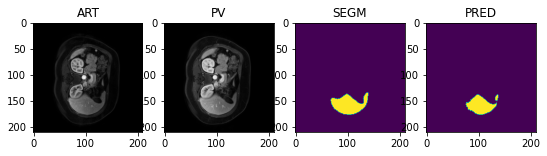

torch.Size([2, 210, 210, 110])
torch.Size([1, 210, 210, 110])
torch.Size([1, 2, 210, 210, 110])
0.9708142280578613
2.0
1.8142317332969806
torch.Size([2, 210, 210, 110])
torch.Size([1, 210, 210, 110])
torch.Size([1, 2, 210, 210, 110])
0.9720937609672546
1.4142135623730951
0.5534393102000691
torch.Size([1, 2, 210, 210, 110])
torch.Size([1, 210, 210, 110])


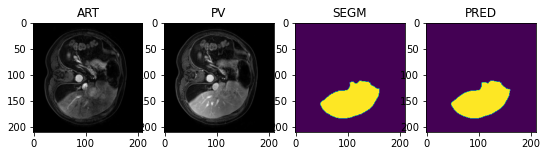

torch.Size([2, 210, 210, 125])
torch.Size([1, 210, 210, 125])
torch.Size([1, 2, 210, 210, 125])
0.8588462471961975
17.46424919657298
3.165206325115861
torch.Size([2, 210, 210, 125])
torch.Size([1, 210, 210, 125])
torch.Size([1, 2, 210, 210, 125])
0.8588462471961975
17.46424919657298
3.165206325115861
torch.Size([1, 2, 210, 210, 125])
torch.Size([1, 210, 210, 125])


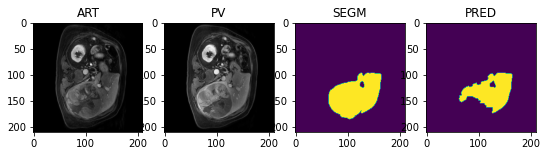

torch.Size([2, 172, 172, 100])
torch.Size([1, 172, 172, 100])
torch.Size([1, 2, 172, 172, 100])
0.9295797348022461
5.830951894845301
1.5817983974249066
torch.Size([2, 172, 172, 100])
torch.Size([1, 172, 172, 100])
torch.Size([1, 2, 172, 172, 100])
0.9298942685127258
5.830951894845301
0.9670878410972338
torch.Size([1, 2, 172, 172, 100])
torch.Size([1, 172, 172, 100])


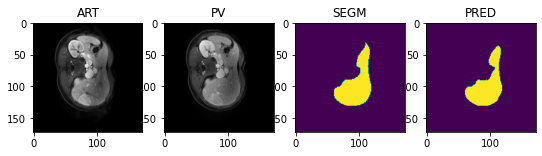

torch.Size([2, 221, 221, 114])
torch.Size([1, 221, 221, 114])
torch.Size([1, 2, 221, 221, 114])
0.8776124119758606
64.66838485689897
17.255024419962375
torch.Size([2, 221, 221, 114])
torch.Size([1, 221, 221, 114])
torch.Size([1, 2, 221, 221, 114])
0.9594551920890808
3.605551275463989
0.7987236204526051
torch.Size([1, 2, 221, 221, 114])
torch.Size([1, 221, 221, 114])


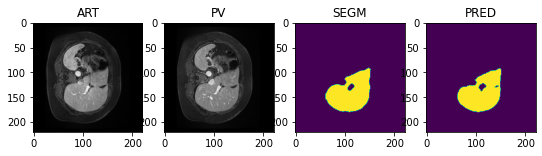

torch.Size([2, 207, 207, 105])
torch.Size([1, 207, 207, 105])
torch.Size([1, 2, 207, 207, 105])
0.9611929059028625
2.449489742783178
0.7701130138676607
torch.Size([2, 207, 207, 105])
torch.Size([1, 207, 207, 105])
torch.Size([1, 2, 207, 207, 105])
0.961341917514801
2.449489742783178
0.6893240460507672
torch.Size([1, 2, 207, 207, 105])
torch.Size([1, 207, 207, 105])


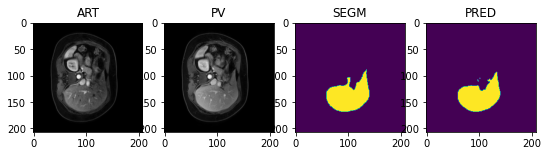

[0.9641662836074829, 0.9787505865097046, 0.9313936829566956, 0.9615792036056519, 0.7755936980247498, 0.8916339874267578, 0.9590423703193665, 0.8939568996429443, 0.90966796875, 0.8211581707000732, 0.894711434841156, 0.9708142280578613, 0.8588462471961975, 0.9295797348022461, 0.8776124119758606, 0.9611929059028625]


,DICE,POST_DICE,HD95,POST_HD95,InferenceTime
count,16.000000,16.000000,16.000000,16.000000,16.000000
mean,0.911231,0.923813,25.405408,10.951936,0.006291
std,0.057916,0.054877,29.043408,15.242443,0.002020
min,0.775594,0.775725,2.000000,1.414214,0.003526
25%,0.888129,0.895966,2.957107,2.733693,0.004567
50%,0.919624,0.942733,9.477841,4.718252,0.006032
75%,0.961289,0.962050,55.313500,10.731947,0.007242
max,0.978751,0.979432,89.476254,54.496330,0.011423


In [28]:
roi_size = (224, 224, 128)

df_external_test_results = run_inference_and_evaluate(
        model=model, 
        data_loader= external_test_loader, 
        roi_size=roi_size, 
        plot_images=True, 
        save_output=False) #, max_eval = 2

torch.cuda.empty_cache()
df_external_test_results['EXPERIMENT_ID'] = 'PARIS-ART-PV'
df_external_test_results.describe()

In [29]:
df_external_test_results.to_csv('../ExternalTestingResults/Paris-ART-PV.csv')